#Chisholm / Prochlorococcus project
##Use Python and its various libraries to link the KEGG compound information with pathways
###KLongnecker, 4/27/2017
Updated to use the compound data corrected for extraction efficiency for all compounds.

In [8]:
if False:
    #this will work to reload whatever I had
    import dill
    dill.load_session('globalsave.pkl')

In [9]:
if False:
    %reset

In [13]:
import pandas as pd
import numpy as np
import re
import os
import glob
import math
from imp import reload
import pdb

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 
#os._exit(1) #this should get me out of the debugging...

%matplotlib inline

In [11]:
mtabFile = 'ChisholmPro_cellSpecific_KEGGexport.2017.04.27_v1.csv' #first column is KEGG C number
mtabData=pd.read_csv(mtabFile, index_col='KEGG')
mtabData.head()

,mtabNames,extEff,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,,,
C00196,2-3-dihydroxybenzoic acid,100.9,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C19675,2-3-dihydroxypropane1sulfonate,0.6,1.502503e-09,0.0,7.559786e-09,0.000000e+00,8.830372e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C08276,3-mercapto proprionate,88.6,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00141,3-methyl-2-oxobutanoic acid,10.1,1.486869e-06,0.0,1.256681e-06,1.702101e-06,3.662957e-08,1.372256e-05,1.173703e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00671,3-methyl-2-oxopentanoic acid,50.1,0.000000e+00,0.0,1.149823e-07,2.144933e-07,0.000000e+00,6.076076e-07,6.064849e-07,1.499082e-09,1.232101e-09,2.171711e-09,1.414847e-10,2.189543e-09


In [12]:
#take out the extra columns: 
mtabData.drop(['extEff','mtabNames'],axis = 1,inplace = True)
mtabData.head()

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,
C00196,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C19675,1.502503e-09,0.0,7.559786e-09,0.000000e+00,8.830372e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C08276,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00141,1.486869e-06,0.0,1.256681e-06,1.702101e-06,3.662957e-08,1.372256e-05,1.173703e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00671,0.000000e+00,0.0,1.149823e-07,2.144933e-07,0.000000e+00,6.076076e-07,6.064849e-07,1.499082e-09,1.232101e-09,2.171711e-09,1.414847e-10,2.189543e-09


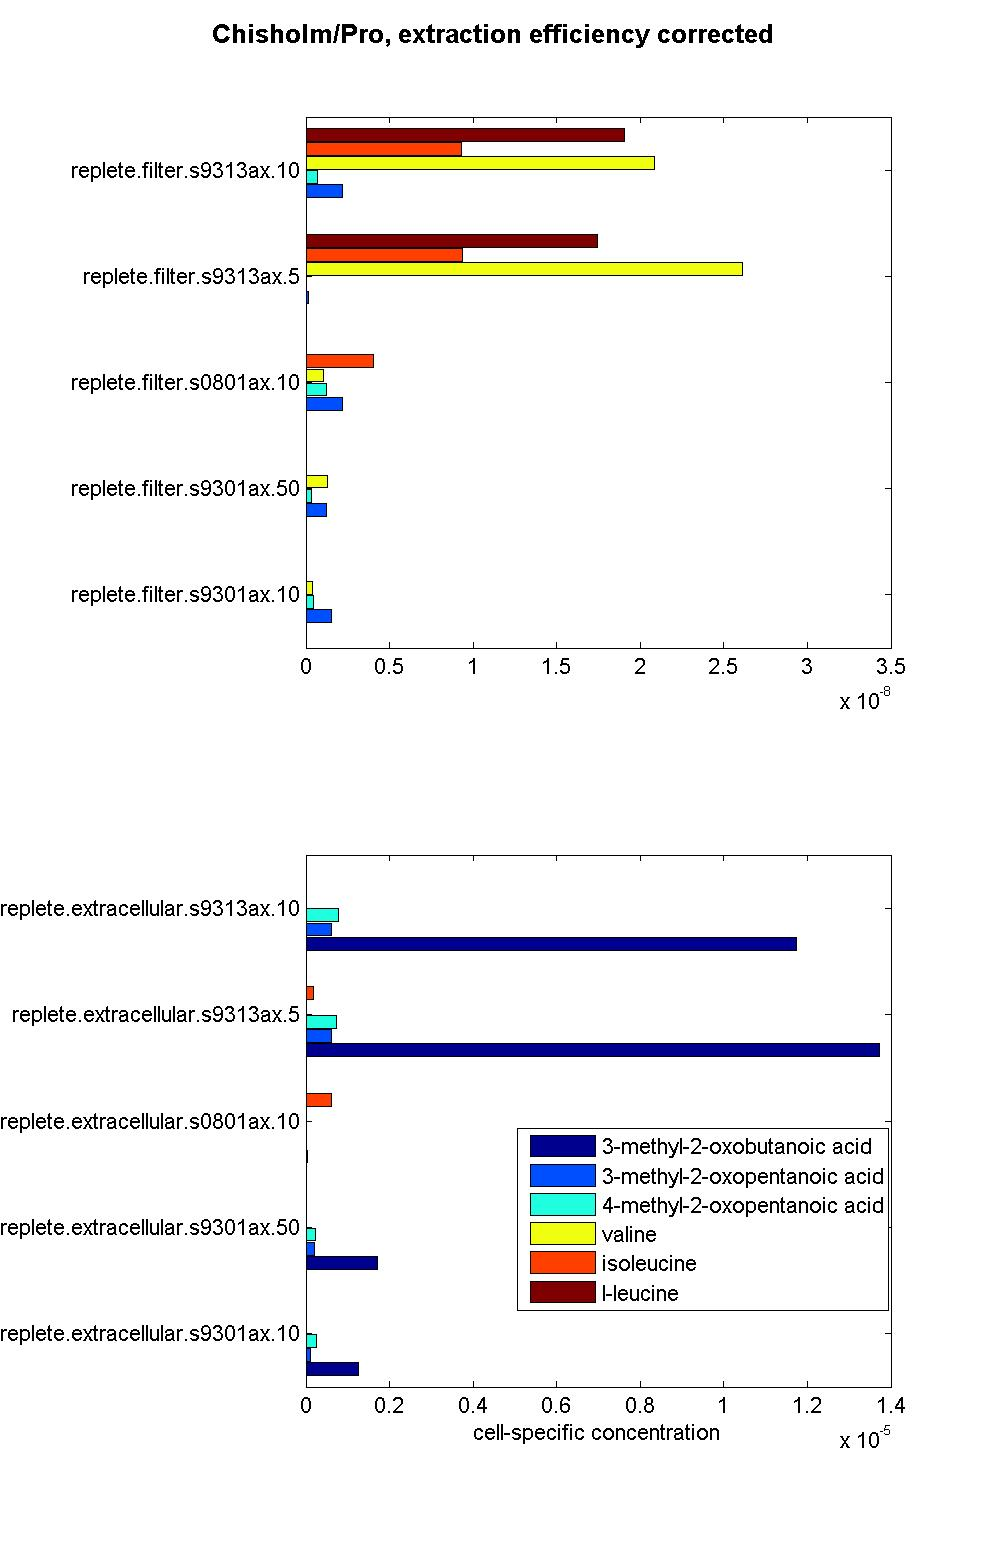

In [8]:
#read in the bar graph with the new acids (from MATLAB)
from IPython.display import Image
Image("Chisholm_Pro_newAcids.2017.04.27.jpg",width=300, height=300)

In [13]:
#allPathways = kegg_list("pathway").read() #all organisms
#pmg is 9301, HLII, #pmt is 9313, LLIV, #prm is 0801, LLI
oneStrain = 'pmg' #use later as well
allPathways = kegg_list("pathway",oneStrain).read() 

len(allPathways.split('\n'))

99

In [14]:
trimPath = []
current_section = None
for line in allPathways.rstrip().split("\n"):
    tp = line[5:13]
    trimPath.append(tp)

In [15]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [16]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
#for this project: can use the three digit code for the different Prochlorococcus strains
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [17]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

In [18]:
#bring in the plotting functions
import plotByGroup
import fxn_plotPathway
##if I make a change, have to reload the function(s):
# reload(fxn_plotPathway)

In [19]:
#have zeros for metabolites that are not in KEGG, need to delete the zeros for now...
mtabPruned = mtabData.drop(['0'])

In [20]:
if False:
    #do all pathways
    for item in trimPath:
        fxn_plotPathway.gatherDetails(item,useFolder,useCO,CO_values)

In [21]:
#organize pathways into the groups defined in the BRITE file
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] is not '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

    return forBrite

In [22]:
#go read in the file from KEGG
D = glob.glob('br08901.keg') #from http://www.genome.jp/kegg-bin/get_htext?br08901.keg; 4/18/2017
allBRITE=[]
for idx,nof in enumerate(D):
    allBRITE = ReadBRITEfile(nof)
    
prunedBRITE = allBRITE.dropna()
prunedBRITE.head()

,map,A,B,C,wholeThing
10,01100,Metabolism,Global and overview maps,Metabolic pathways,C 01100 Metabolic pathways\n
11,01110,Metabolism,Global and overview maps,Biosynthesis of secondary metabolites,C 01110 Biosynthesis of secondary metaboli...
12,01120,Metabolism,Global and overview maps,Microbial metabolism in diverse environments,C 01120 Microbial metabolism in diverse en...
13,01130,Metabolism,Global and overview maps,Biosynthesis of antibiotics,C 01130 Biosynthesis of antibiotics\n
14,01200,Metabolism,Global and overview maps,Carbon metabolism,C 01200 Carbon metabolism\n


In [23]:
#probably a way to do this in one step...only want 'metabolism' biochemical pathways
findM = prunedBRITE.loc[(prunedBRITE['A'] == 'Metabolism')]
findU = findM.loc[:,'B']

#really not that many pathway groups
findU.unique()

array(['Global and overview maps', 'Carbohydrate metabolism',
       'Energy metabolism', 'Lipid metabolism', 'Nucleotide metabolism',
       'Amino acid metabolism', 'Metabolism of other amino acids',
       'Glycan biosynthesis and metabolism',
       'Metabolism of cofactors and vitamins',
       'Metabolism of terpenoids and polyketides',
       'Biosynthesis of other secondary metabolites',
       'Xenobiotics biodegradation and metabolism',
       'Chemical structure transformation maps'], dtype=object)

In [24]:
unMetabolismGroups = findU.unique()
unMetabolismGroups = np.delete(unMetabolismGroups,(0),axis=0) #skip over the global and overview maps

In [25]:
#now that I have the colors all set...let's think about what we actually want to plot...
list(mtabPruned)

['Plimited_extracellular_s9301ax_50',
 'Plimited_filter_s9301ax_50',
 'replete_extracellular_s9301ax_10',
 'replete_extracellular_s9301ax_50',
 'replete_extracellular_s0801ax_10',
 'replete_extracellular_s9313ax_5',
 'replete_extracellular_s9313ax_10',
 'replete_filter_s9301ax_10',
 'replete_filter_s9301ax_50',
 'replete_filter_s0801ax_10',
 'replete_filter_s9313ax_5',
 'replete_filter_s9313ax_10']

In [26]:
#oneStrain = 'pmg' #run for one strain that has been set above(options are 'pmg','pmt','prm')
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  

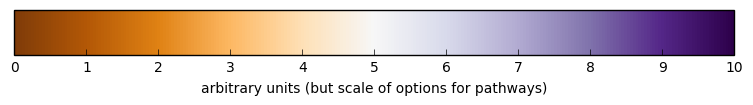

In [27]:
import colorbar_only

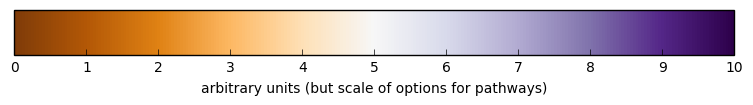

<module 'colorbar_only' from 'C:\\Users\\krista\\Documents\\GitHub\\Pro_mtabs\\colorbar_only.py'>

In [28]:
reload(colorbar_only)
#this will be the range of colors in the pathway maps (not green bc genes are green)

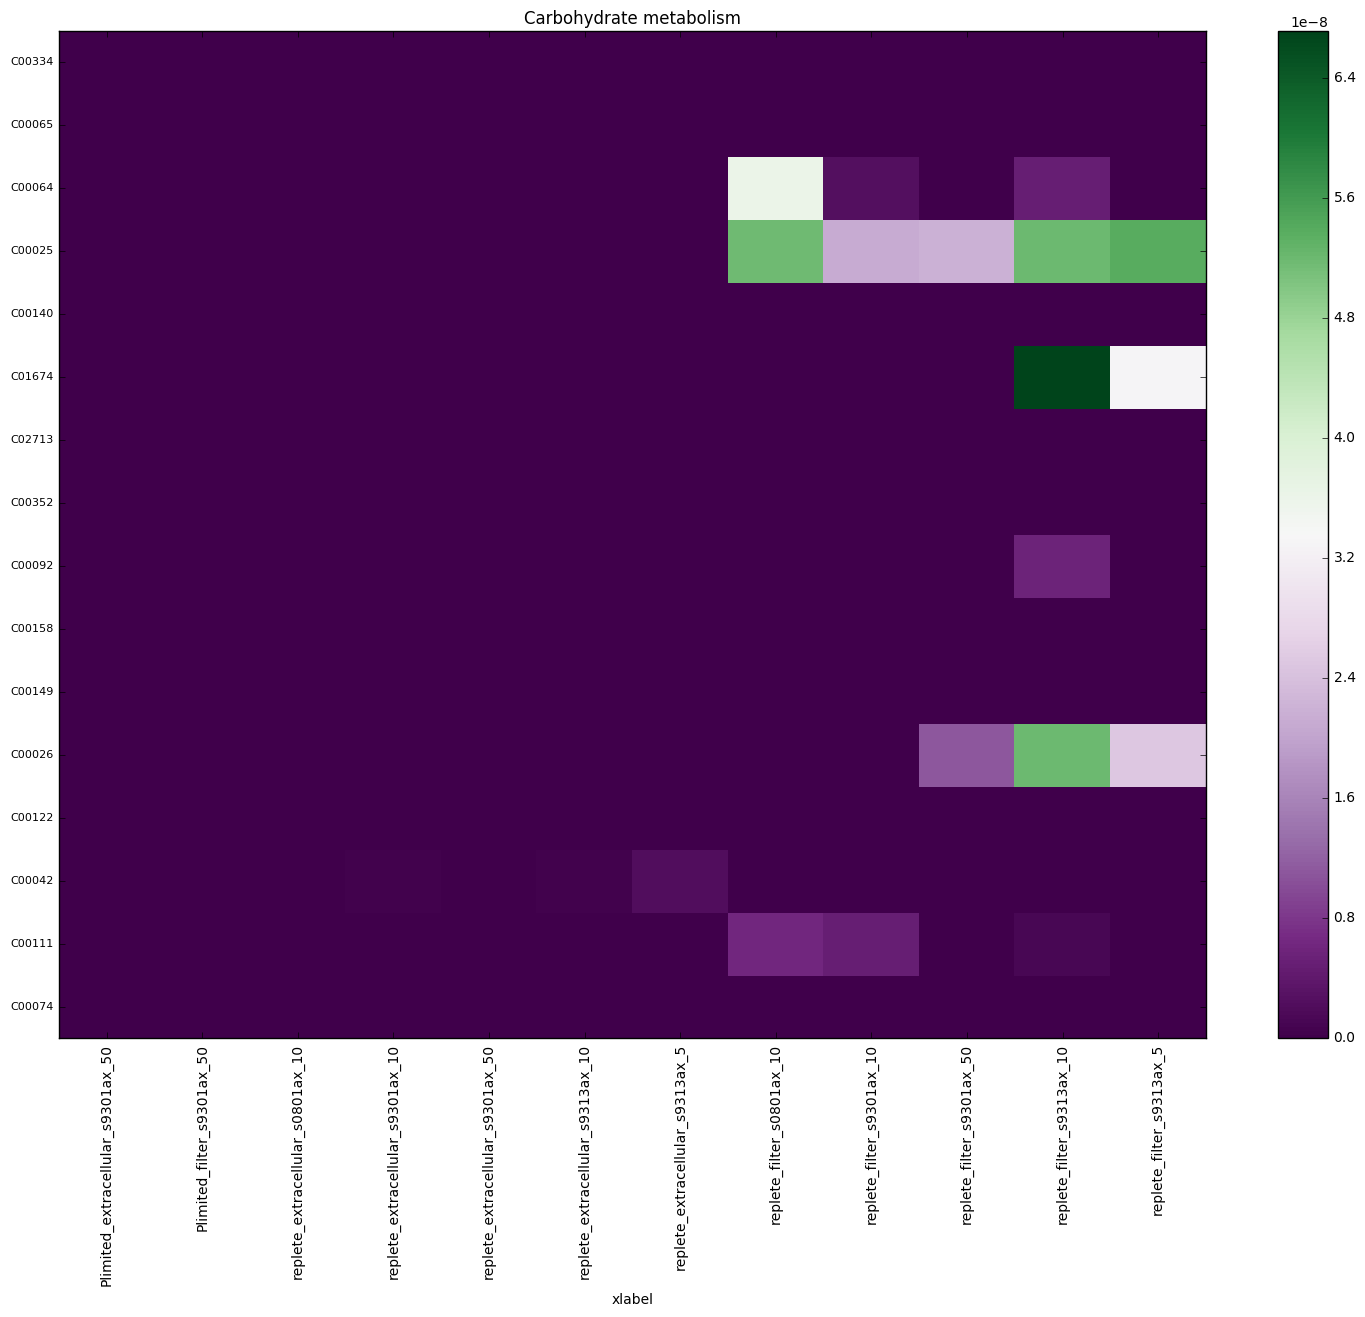

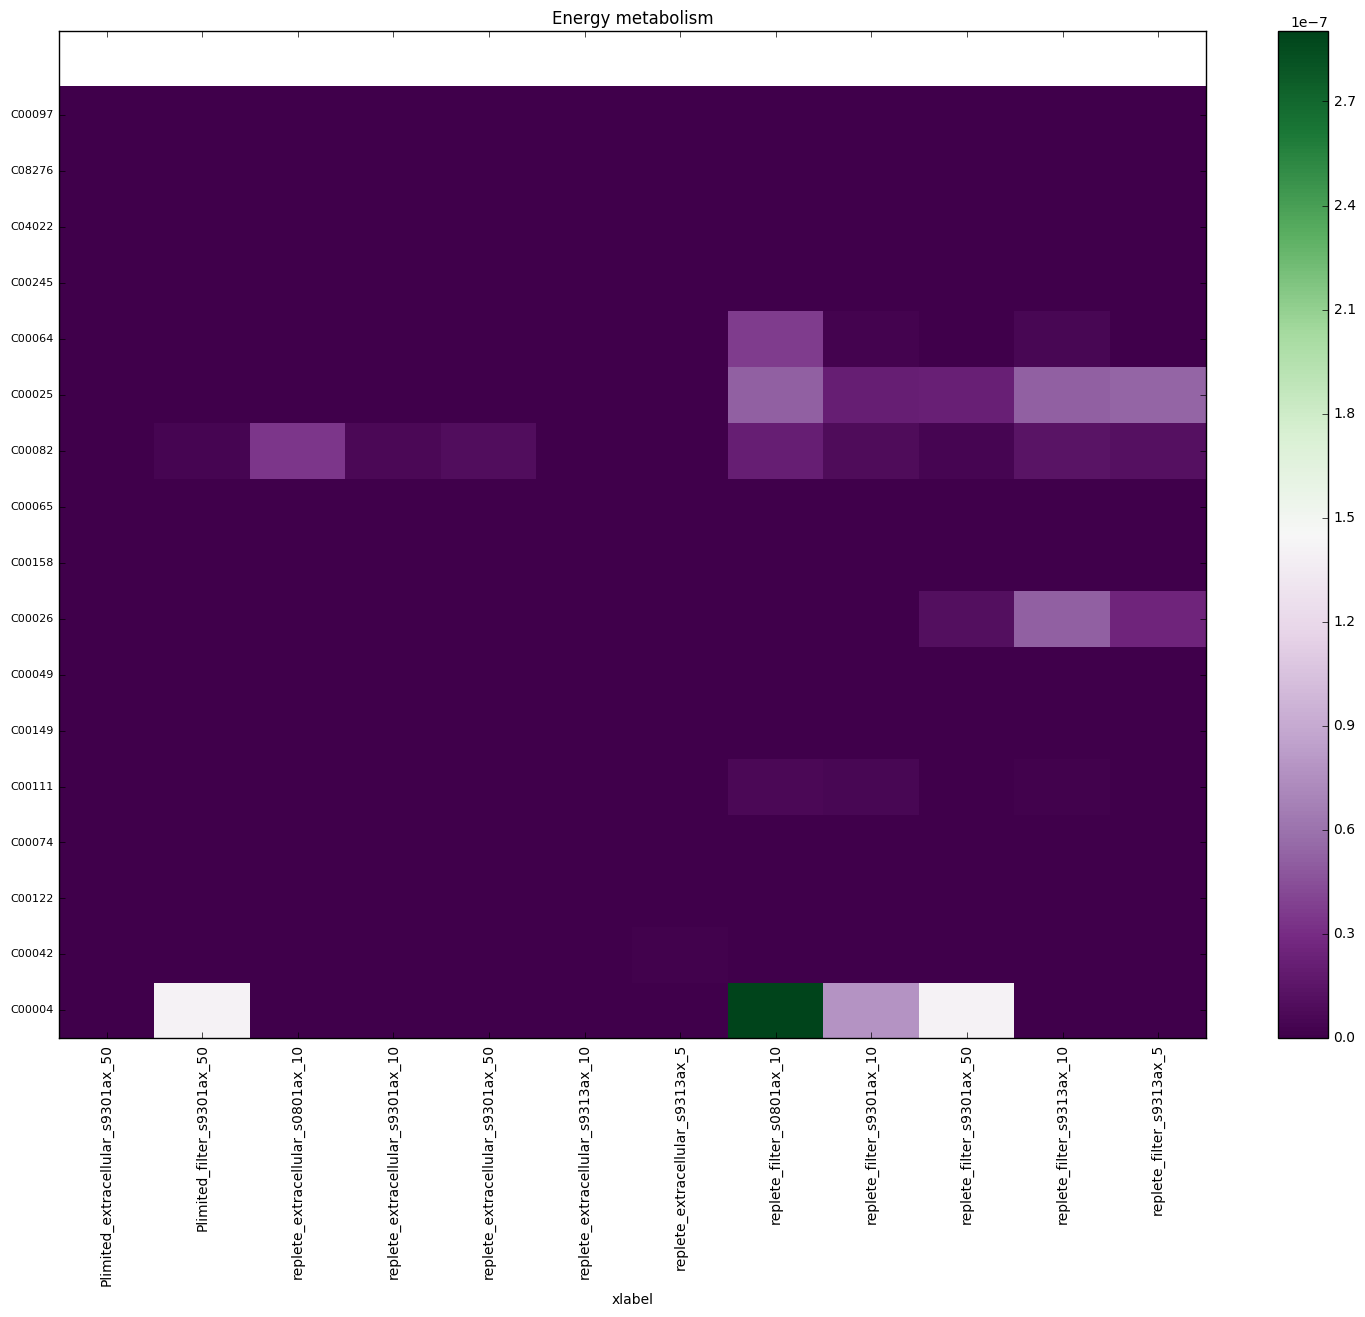

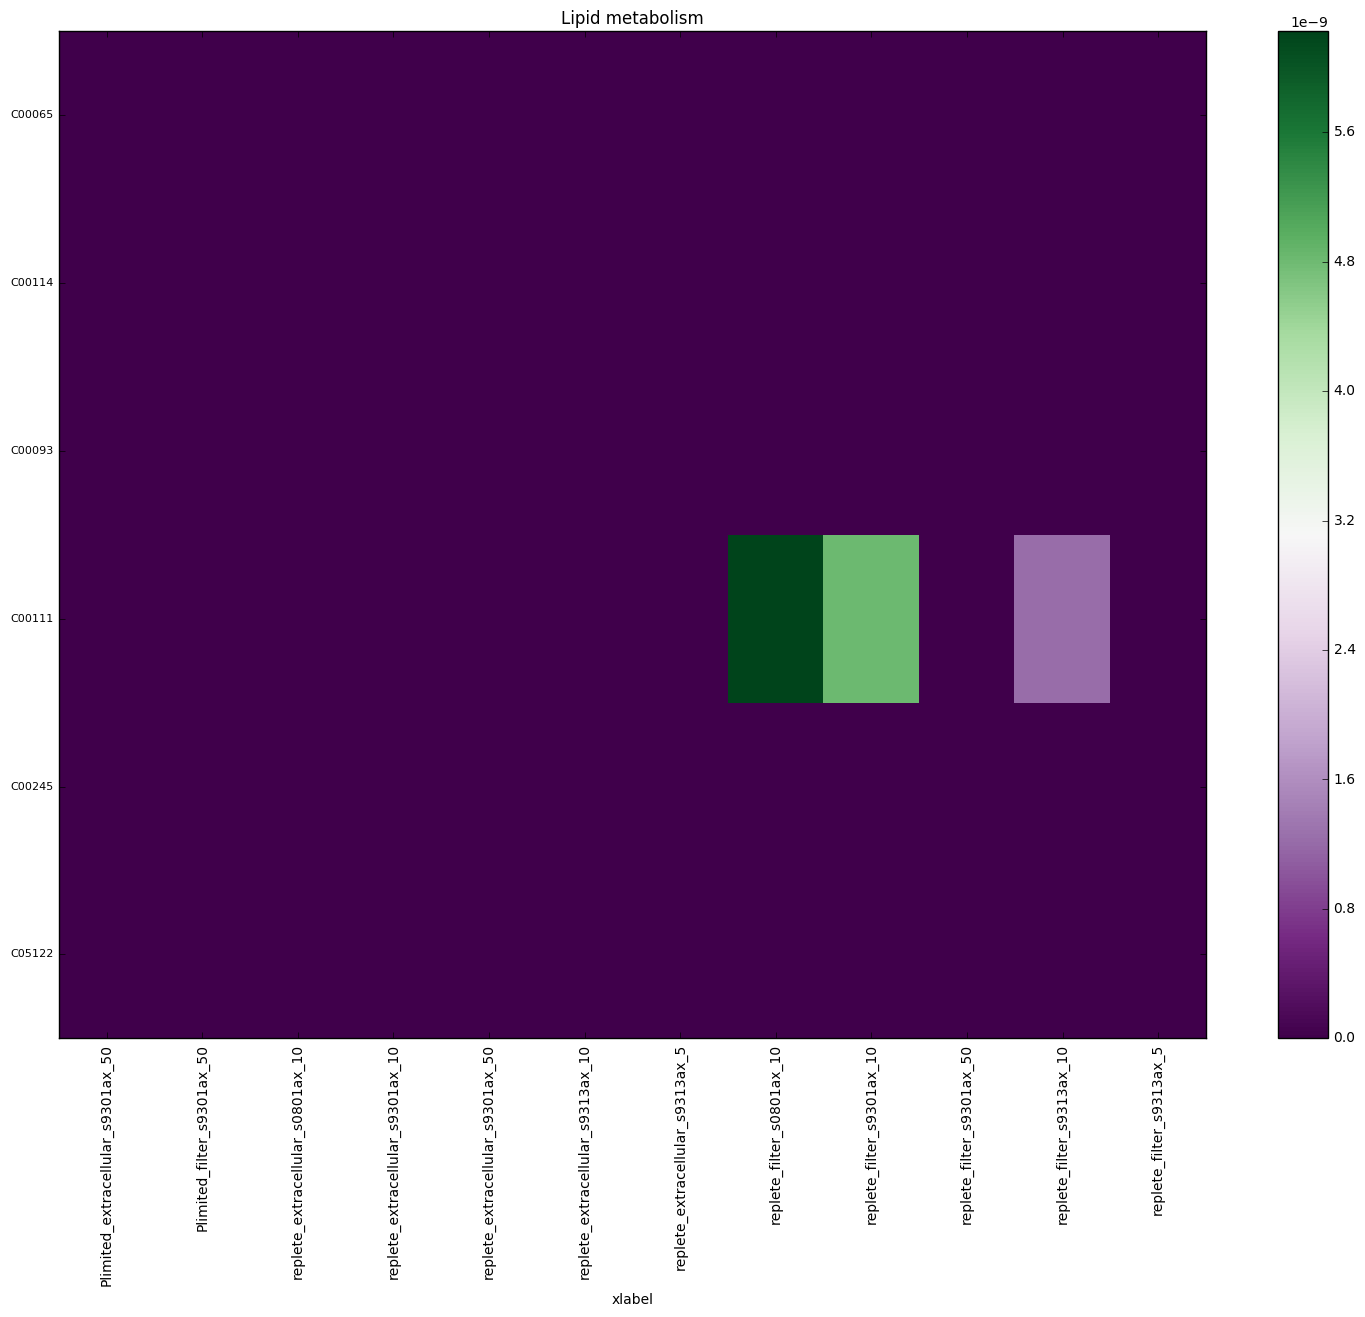

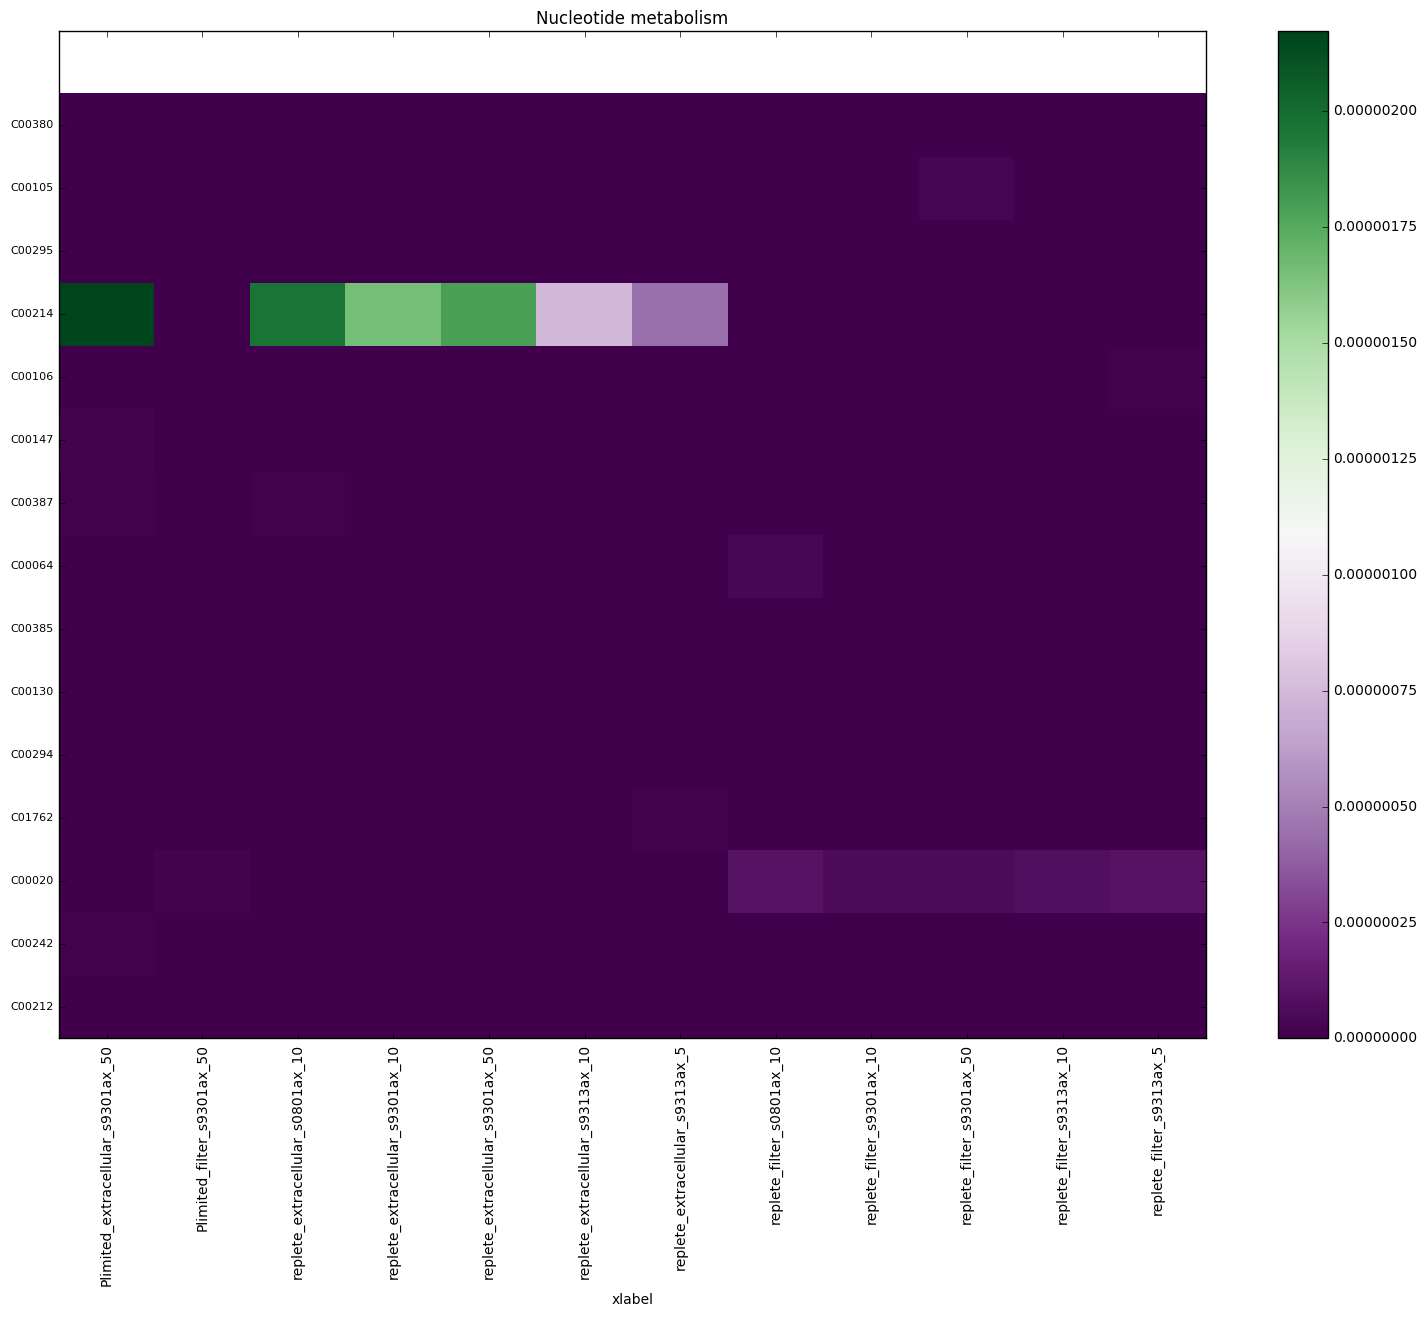

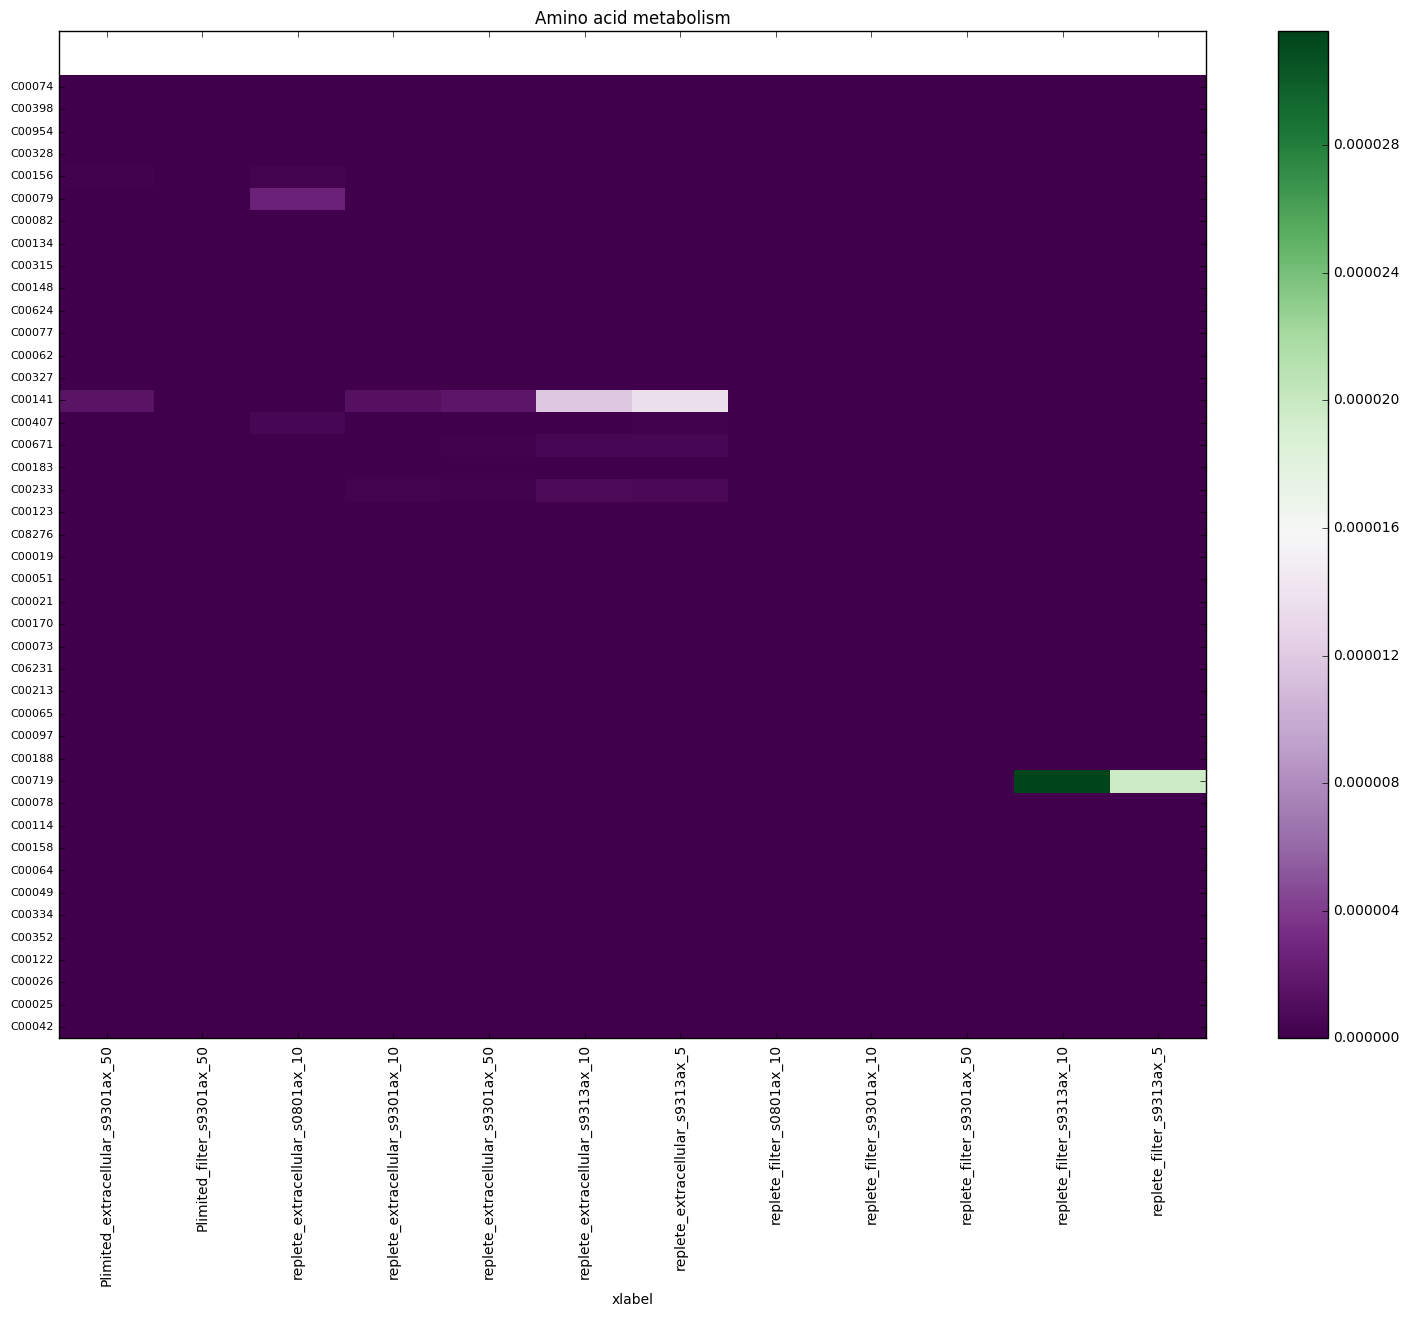

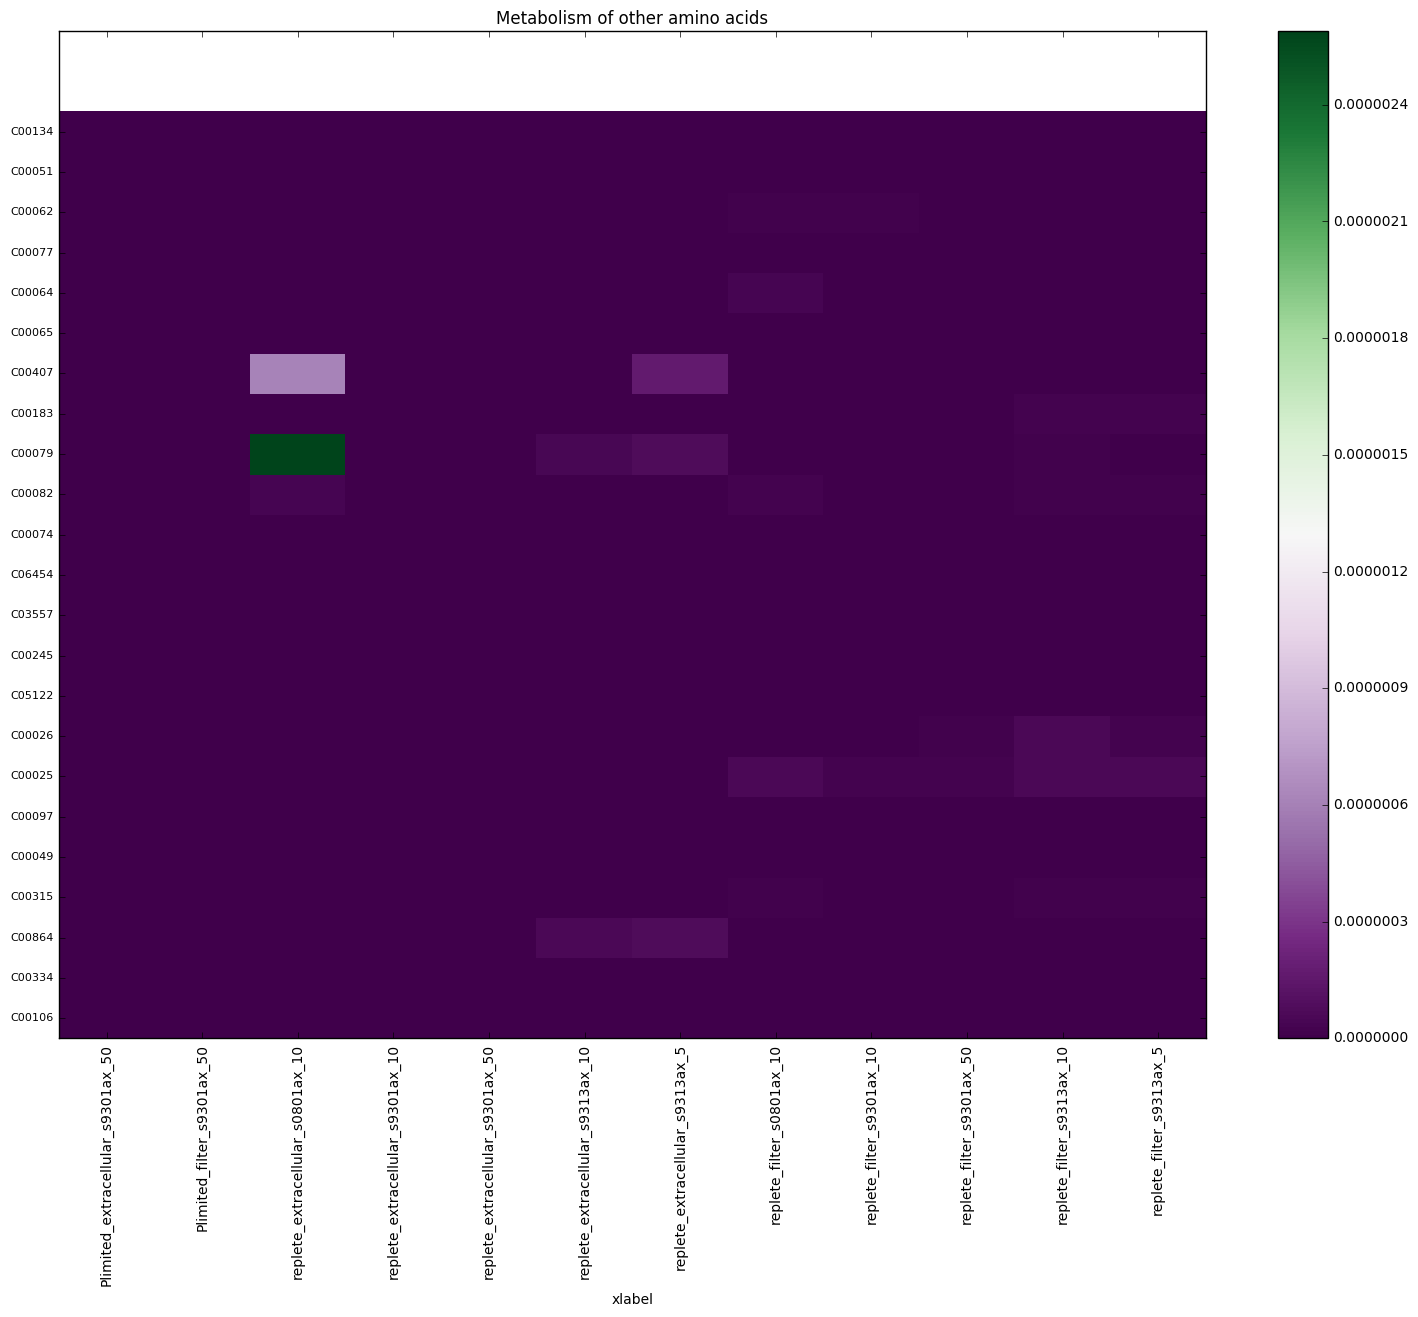

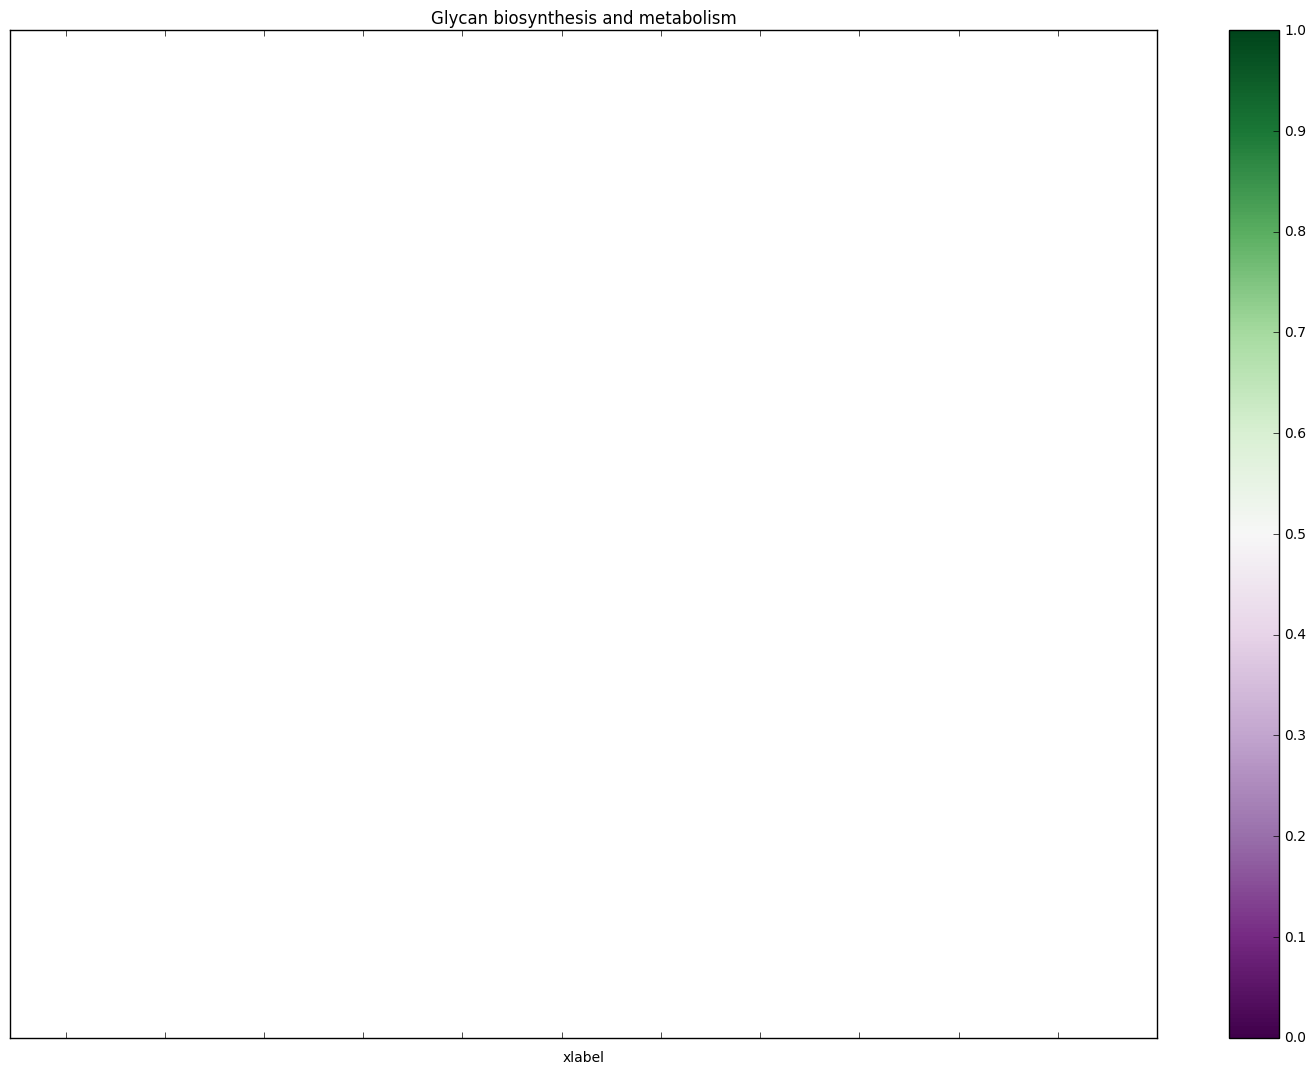

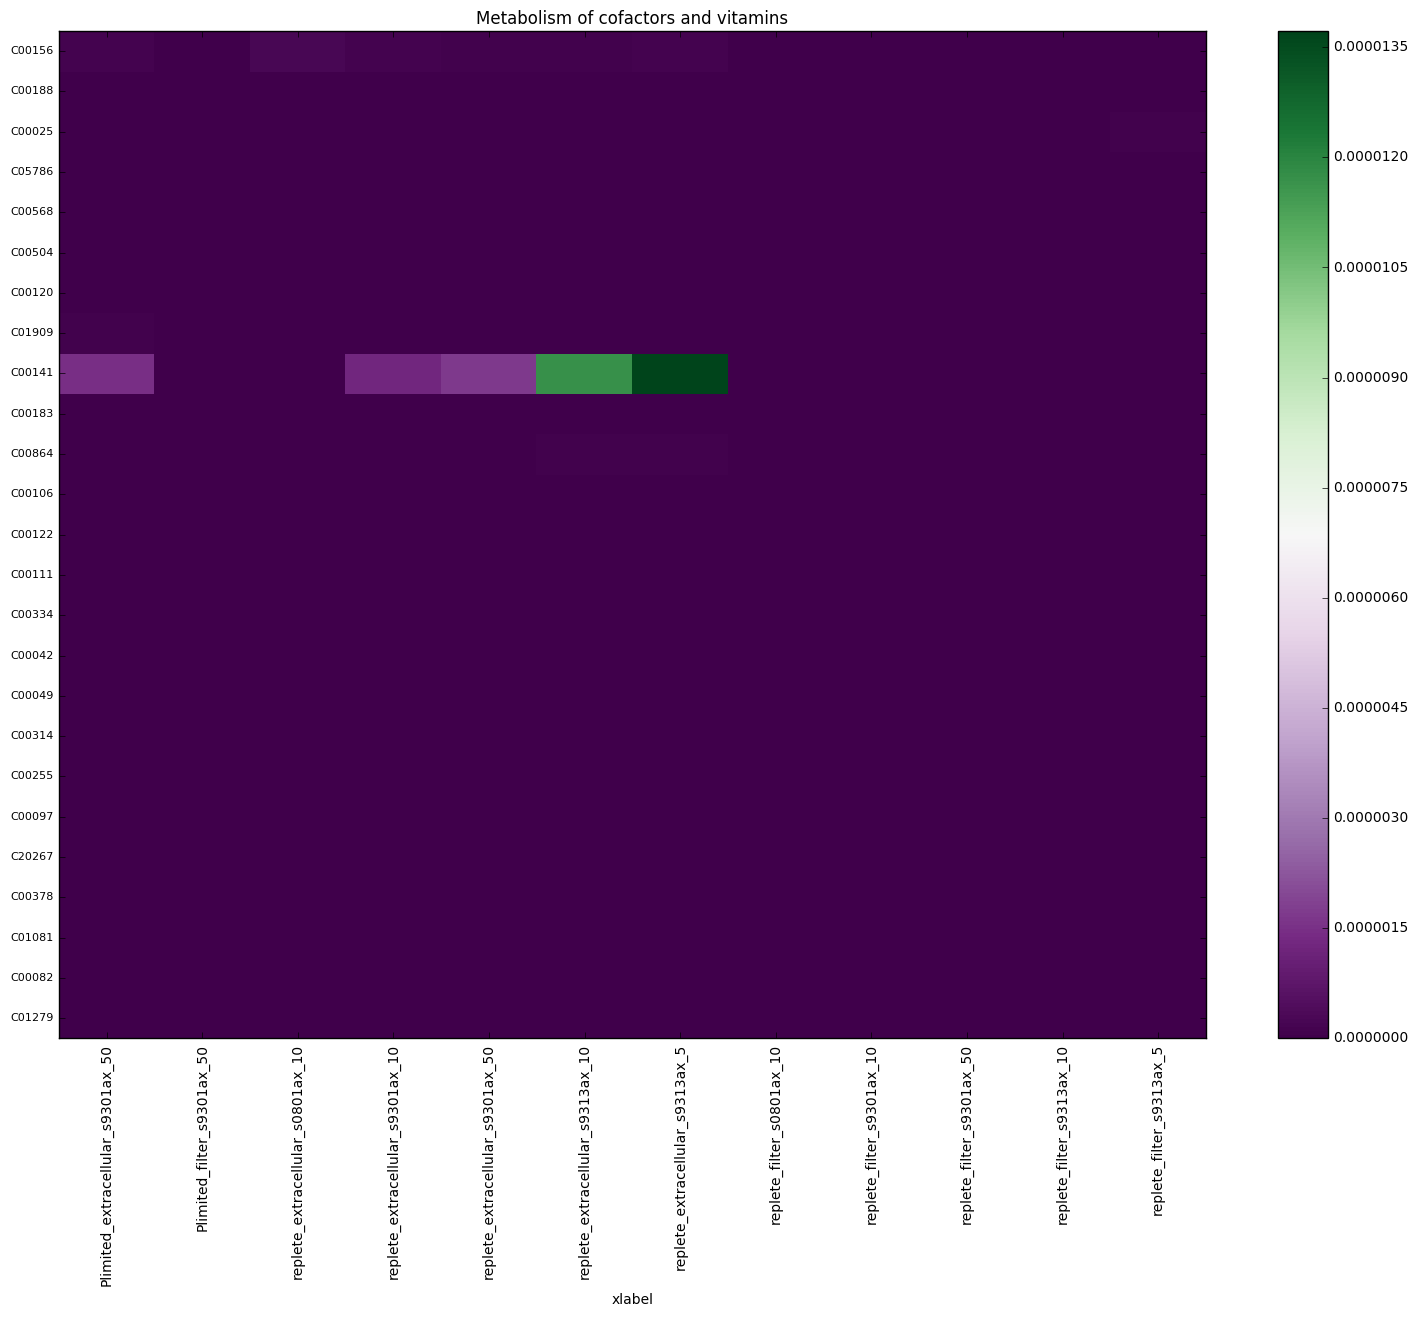

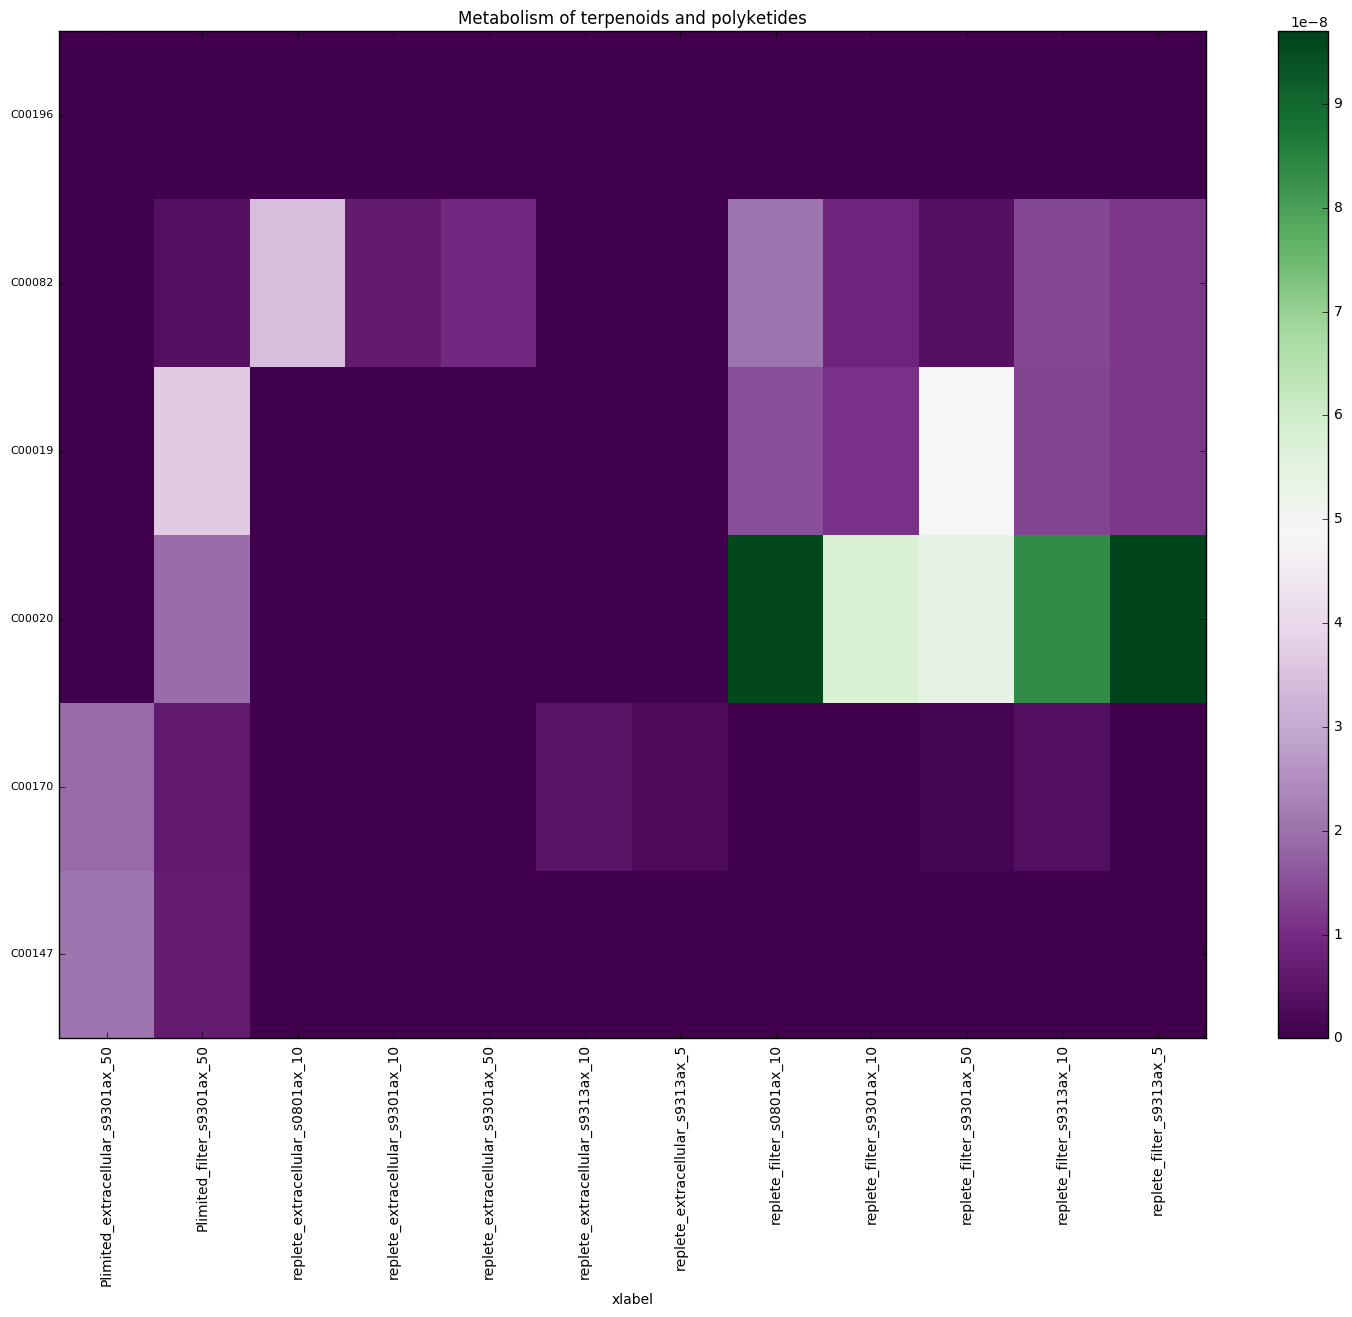

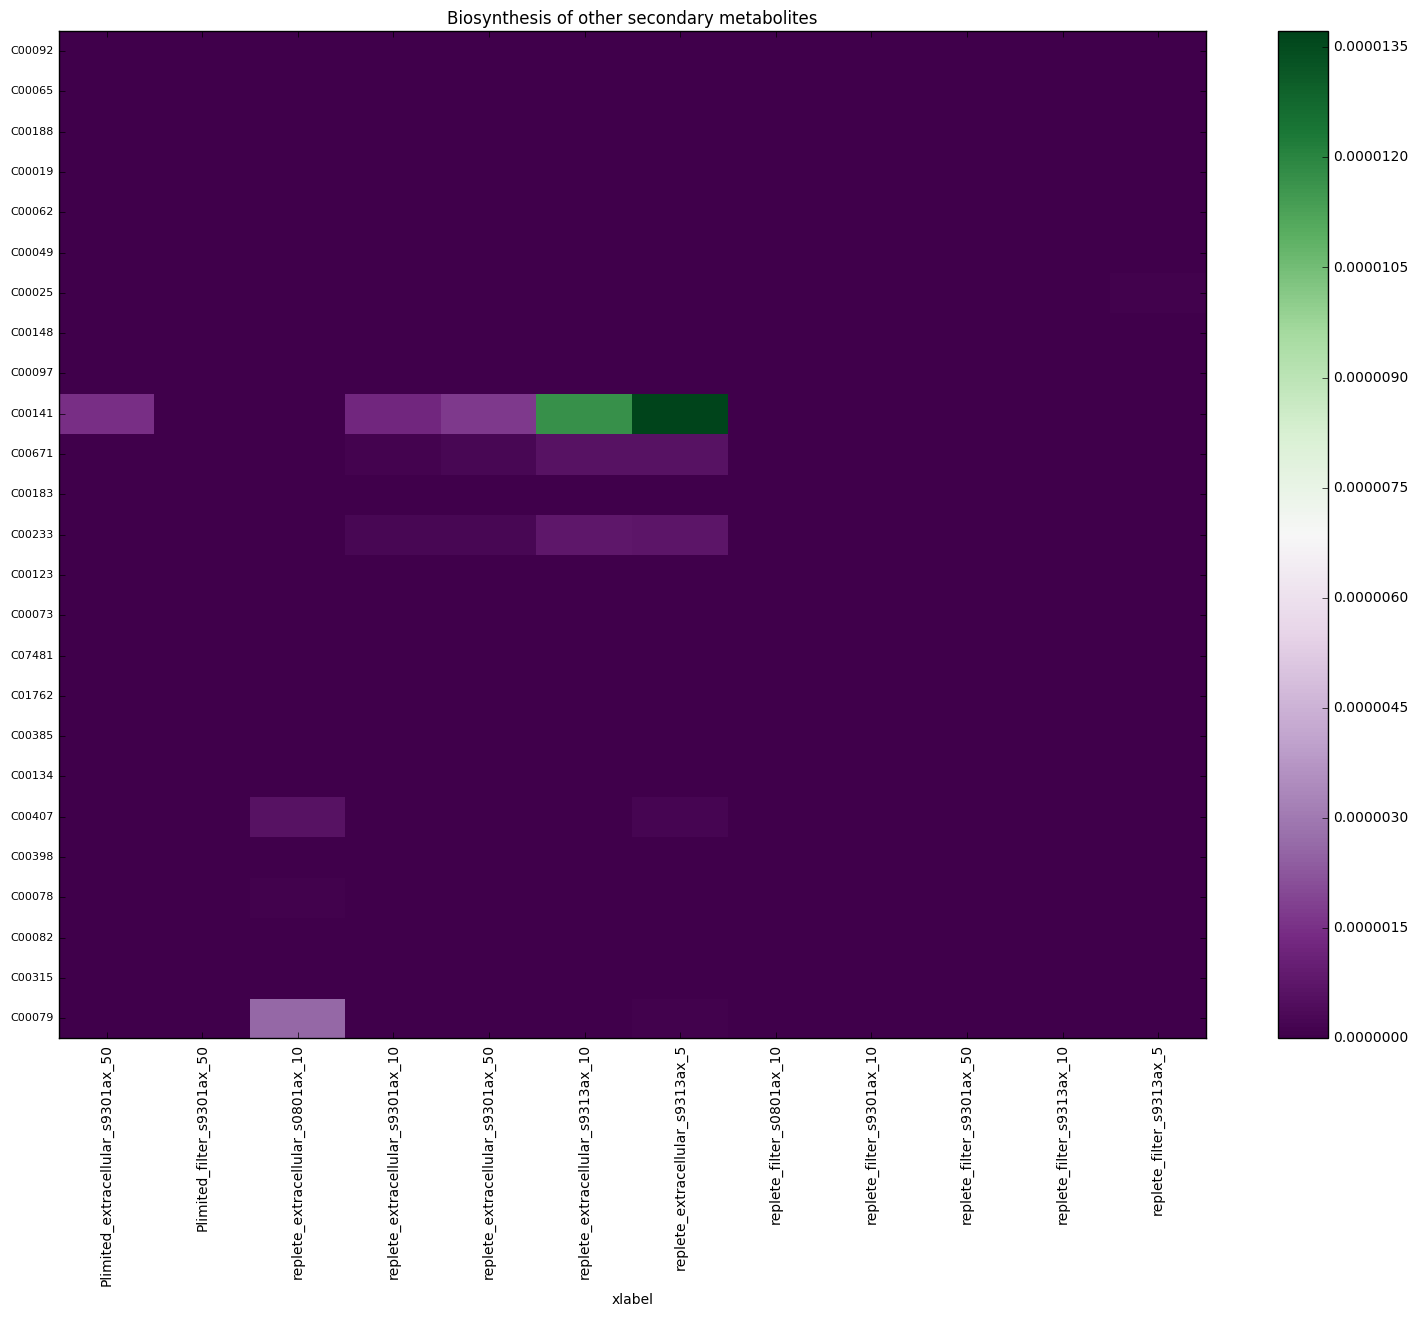

problem with this pathway 00983


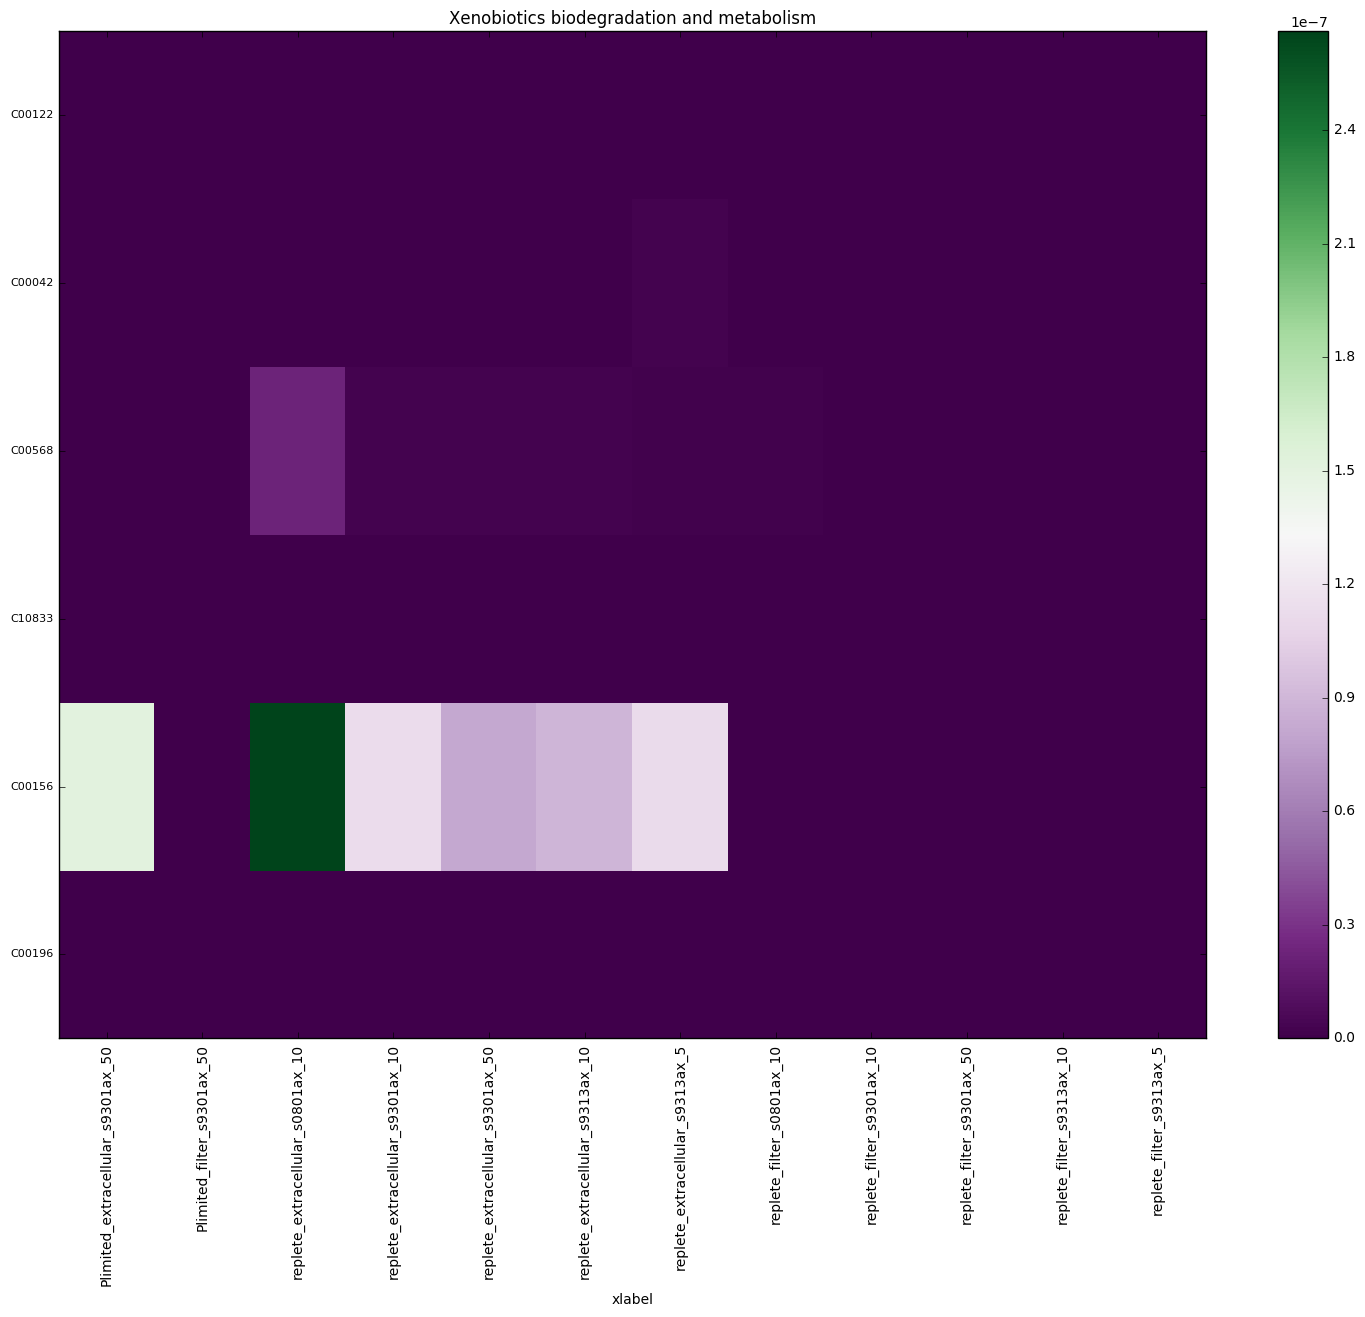

problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070


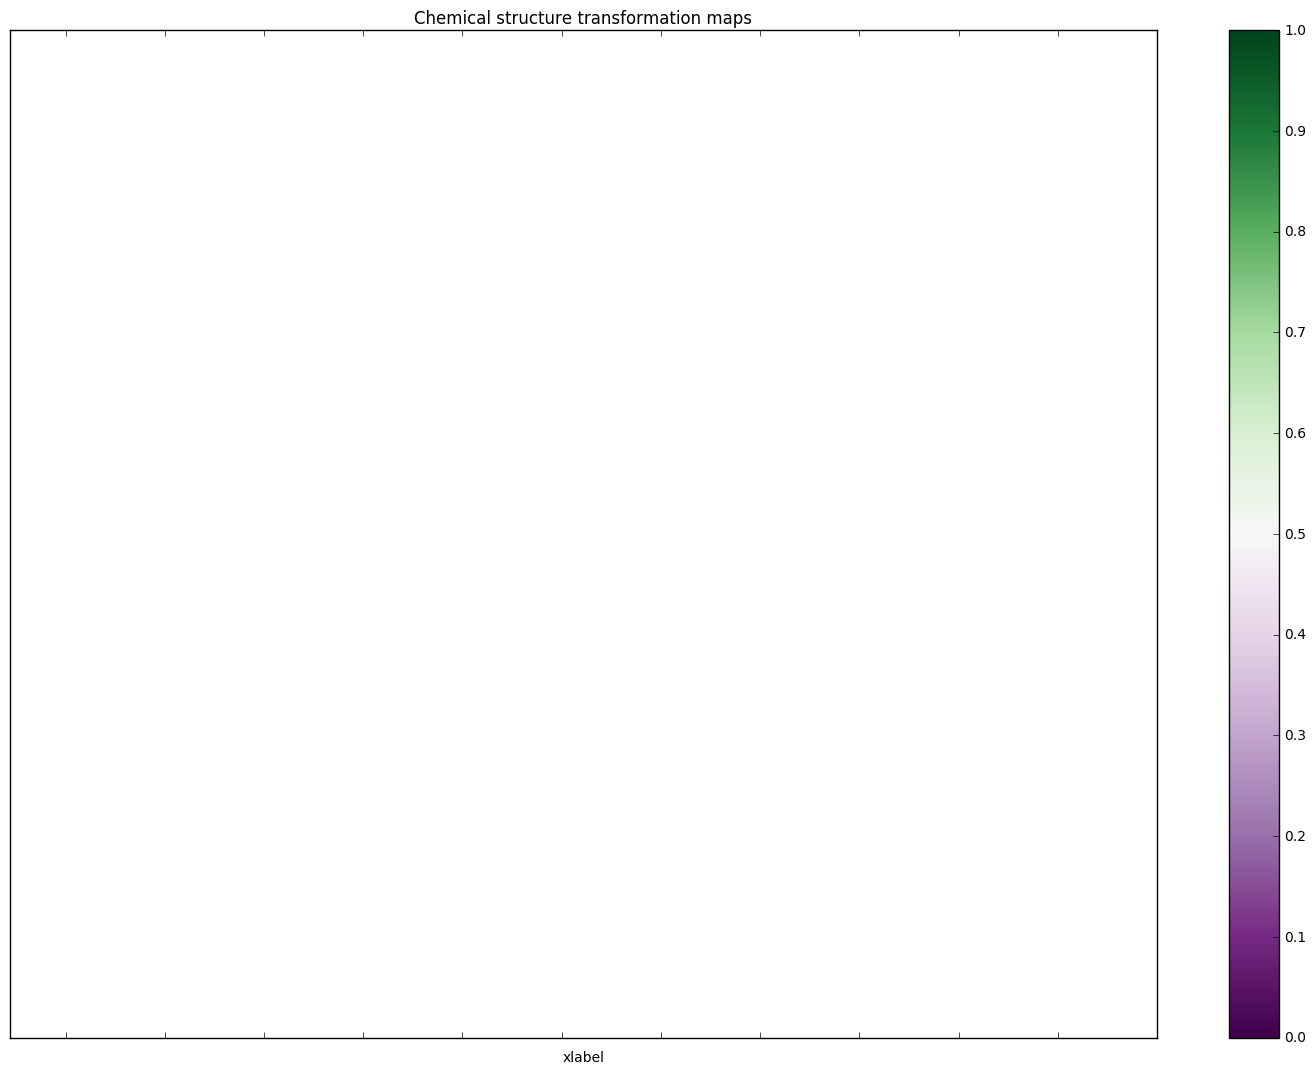

In [29]:
if True:
    ##this will take a while...
    for oneGroup in unMetabolismGroups:
        shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
        onePath = shortList.loc[:,'map']
        onePath_ann = []
        for item in onePath:
            onePath_ann.append(oneStrain + item)

        #plot pathways divided by group, remember...can have pathways not annotated for this Pro strain
        for runOne in onePath_ann:    
            try:
                fxn_plotPathway.gatherDetails(runOne,oneGroup,useCO,CO_values)               
            except:
                print('problem with this pathway ' + item)

        #next line will make the color maps for each group: purple = low; green = high
        plotByGroup.plotGroup(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain)

In [30]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

In [31]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted

In [32]:
pmgPathways = kegg_list('pathway','pmg').read()
pmgTrim = trimPath(pmgPathways)

In [33]:
prmPathways = kegg_list('pathway','prm').read()
prmTrim = trimPath(prmPathways)

In [34]:
pmtPathways = kegg_list('pathway','pmt').read()
pmtTrim = trimPath(pmtPathways)

In [35]:
#what about set different?
def diff(list1, list2):
    c = set(list1).union(set(list2))
    d = set(list1).intersection(set(list2))
    return list(c - d)

In [36]:
out = diff(pmtTrim, pmgTrim)

In [37]:
inTwo = set(pmgTrim).intersection(set(prmTrim))
d = set(pmgTrim).difference(set(prmTrim))

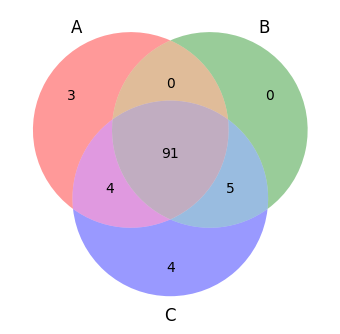

In [38]:
venn3_unweighted(subsets = (set(pmgTrim),set(prmTrim),set(pmtTrim)))

In [39]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

In [40]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimGenes(geneString):
    export_trimGenes = []
    current_section = None
    for line in geneString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        r = line.find('ko:')
        tp = line[r+3 : r+9]
        export_trimGenes.append(tp)
    return export_trimGenes

In [41]:
#pull the full set of genes for each strain...
pmtGenes = kegg_link("ko","pmt").read()
pmtGenes = trimGenes(pmtGenes)

In [42]:
#pull the full set of genes for each strain...
pmgGenes = kegg_link("ko","pmg").read()
pmgGenes = trimGenes(pmgGenes)

In [43]:
#pull the full set of genes for each strain...can do this in one step...
prmGenes = trimGenes(kegg_link("ko","prm").read())

In [44]:
#pull the full set of compounds for each strain...
#have to loop through because the KEGG / REST code will not do this 

In [45]:
#setup the strings to match first
rnString = re.compile('(?:[rn:R])(\d+)$') #will return R00190
cpdString = re.compile('(?:[cpd:C])(\d+)$') #will return C00190

pmg_countCpd = []
pmg_countGene = []
pmg_countRxn = []
        
for gen in pmgGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            pmg_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    pmg_countCpd.append(m2) 
                    pmg_countGene.append(gen)

In [46]:
pmt_countCpd = []
pmt_countGene = []
pmt_countRxn = []

for gen in pmtGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            pmt_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    pmt_countCpd.append(m2) 
                    pmt_countGene.append(gen)

In [47]:
prm_countCpd = []
prm_countGene = []
prm_countRxn = []

for gen in prmGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            prm_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    prm_countCpd.append(m2) 
                    prm_countGene.append(gen)

In [48]:
#now, consider the overlap in compounds among the three strains

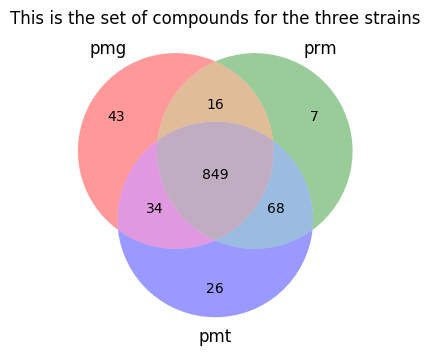

In [49]:
venn3_unweighted(subsets = (set(pmg_countCpd),set(prm_countCpd),set(pmt_countCpd)),set_labels = 
                 ('pmg','prm','pmt'))
plt.title('This is the set of compounds for the three strains')
#plt.show() #don't do this...this creates a new figure
plt.savefig('Pro_cpds.png')

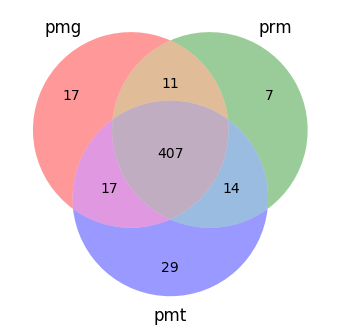

In [50]:
v = venn3_unweighted(subsets = (set(pmg_countGene),set(prm_countGene),set(pmt_countGene)),set_labels = 
                 ('pmg','prm','pmt'))

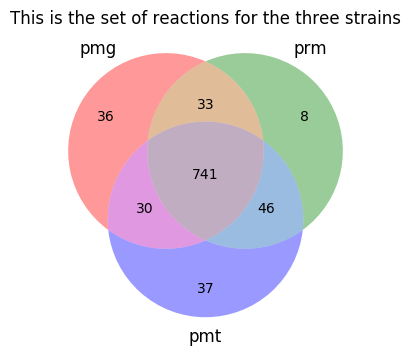

In [51]:
v = venn3_unweighted(subsets = (set(pmg_countRxn),set(prm_countRxn),set(pmt_countRxn)),set_labels = 
                 ('pmg','prm','pmt'))
plt.title('This is the set of reactions for the three strains')
#plt.show() #don't do this...this creates a new figure
#plt.savefig('testing.png')

In [52]:
len(set(pmg_countGene) & set(prm_countGene)- set(pmt_countGene))

11

In [53]:
len(set(pmg_countGene) & set(pmt_countGene)- set(prm_countGene))

17

In [54]:
len(set(prm_countGene) - (set(pmg_countGene)| set(pmt_countGene)))

7

In [56]:
set(prm_countGene) - (set(pmg_countGene)| set(pmt_countGene))

{'K00101', 'K00978', 'K01623', 'K01709', 'K01725', 'K01953', 'K18827'}

In [57]:
set(prm_countCpd) - (set(pmg_countCpd)| set(pmt_countCpd))

{'C00186', 'C00501', 'C01219', 'C01417', 'C20761', 'C20762', 'C20763'}

In [58]:
len(set(prm_countRxn) - (set(pmg_countRxn)| set(pmt_countRxn)))

8

In [59]:
rxnString = set(prm_countRxn) - (set(pmg_countRxn)| set(pmt_countRxn))
#rxnString = set(pmg_countRxn) - (set(prm_countRxn)| set(pmt_countRxn))
#rxnString = set(pmt_countRxn) - (set(prm_countRxn)| set(pmg_countRxn))

In [60]:
for line in rxnString:
    #print(line)
    print(kegg_get(line).read())

ENTRY       R03546                      Reaction
NAME        carbamate hydro-lyase;
            cyanate hydratase;
            cyanate C-N-lyase
DEFINITION  Cyanate + H+ + HCO3- <=> CO2 + Carbamate
EQUATION    C01417 + C00080 + C00288 <=> C00011 + C01563
COMMENT     first step of two-step reaction (see R10079, R03546+R07316)
            bicarbonate is recycled (see R10092)
RCLASS      RC00952  C01417_C01563
            RC02807  C00011_C00288
ENZYME      4.2.1.104
PATHWAY     rn00910  Nitrogen metabolism
ORTHOLOGY   K01725  cyanate lyase [EC:4.2.1.104]
REFERENCE   1  [PMID:3110153]
            Johnson WV, Anderson PM.
            Bicarbonate is a recycling substrate for cyanase.
            J. Biol. Chem. 262 (1987) 9021-5.
            2  [PMID:7947823]
            Anderson PM, Korte JJ, Holcomb TA.
            Reaction of the N-terminal methionine residues in cyanase with diethylpyrocarbonate.
            Biochemistry. 33 (1994) 14121-5.
///

ENTRY       R02426                      Rea

In [61]:
cpdString = set(prm_countCpd) - (set(pmg_countCpd)| set(pmt_countCpd))
for item in cpdString:
    print(kegg_list(item).read())

cpd:C20762	3-O-Phospho-alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-[alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)]n-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-alpha-D-GlcNAc-diphospho-ditrans,octacis-undecaprenol

cpd:C20763	3-O-Methylphospho-alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-[alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)]n-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-alpha-D-GlcNAc-diphospho-ditrans,octacis-undecaprenol

cpd:C01219	CDP-4-dehydro-6-deoxy-D-glucose

cpd:C00501	CDP-glucose; CDP-D-Glucose

cpd:C20761	alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-[alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)]n-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-alpha-D-GlcNAc-diphospho-ditrans,octacis-undecaprenol

cpd:C01417	Cyanate; Cyanic acid

cpd:C00186	(S)-Lactate; L-Lactate; L-Lactic acid



In [62]:
cpdString = set(pmg_countCpd) - (set(prm_countCpd)| set(pmt_countCpd))
for item in cpdString:
    print(kegg_list(item).read())

cpd:C05715	gamma-Amino-gamma-cyanobutanoate; 4-Amino-4-cyanobutanoic acid

cpd:C00282	Hydrogen; H2

cpd:C04294	5-(2-Hydroxyethyl)-4-methylthiazole; 4-Methyl-5-(2'-hydroxyethyl)-thiazole; 4-Methyl-5-(2-hydroxyethyl)-thiazole

cpd:C05678	(2-Amino-1-hydroxyethyl)phosphonate; 1-Hydroxy-2-aminoethylphosphonate

cpd:C03440	cis-4-Hydroxy-D-proline

cpd:C03921	2-Dehydro-3-deoxy-D-glucarate

cpd:C00270	N-Acetylneuraminate; N-Acetylneuraminic acid; 5-Acetamido-3,5-dideoxy-D-glycero-D-galacto-2-nonulosonic acid; Neu5Ac

cpd:C01401	Alanine; 2-Aminopropionic acid; 2-Aminopropanoic acid

cpd:C01146	2-Hydroxy-3-oxopropanoate; Tartronate semialdehyde

cpd:C00679	5-Dehydro-4-deoxy-D-glucarate; (2R,3S)-2,3-Dihydroxy-5-oxohexanedioate

cpd:C07836	D-glycero-beta-D-manno-Heptose 7-phosphate

cpd:C04712	(7R)-7-(5-Carboxy-5-oxopentanoyl)aminocephalosporinate

cpd:C19878	D-glycero-alpha-D-manno-Heptose 7-phosphate

cpd:C19882	D-glycero-D-manno-Heptose 7-phosphate

cpd:C00128	CMP-N-acetylneuraminate; CMP-N-ace

In [63]:
cpdString = set(pmt_countCpd) - (set(prm_countCpd)| set(pmg_countCpd))
for item in cpdString:
    print(kegg_list(item).read())

cpd:C01879	Pidolic acid; 5-Oxoproline; Pyroglutamic acid; 5-Pyrrolidone-2-carboxylic acid; Pyroglutamate; 5-Oxo-L-proline; L-Pyroglutamic acid; L-5-Pyrrolidone-2-carboxylic acid

cpd:C01112	D-Arabinose 5-phosphate

cpd:C00534	Pyridoxamine; PM

cpd:C01190	beta-D-Glucosyl-(1<->1)-ceramide; Glucosylceramide; Glucocerebroside; D-Glucosyl-N-acylsphingosine

cpd:C00018	Pyridoxal phosphate; Pyridoxal 5-phosphate; Pyridoxal 5'-phosphate; PLP

cpd:C01170	UDP-N-acetyl-D-mannosamine; UDP-N-acetyl-alpha-D-mannosamine

cpd:C00195	N-Acylsphingosine; Ceramide; N-Acylsphing-4-enine; (4E)-Sphing-4-enine ceramide

cpd:C01180	4-Methylthio-2-oxobutanoic acid; 4-Methylthio-2-oxobutanoate; 2-Keto-4-methylthiobutyric acid; 2-Oxo-4-methylthiobutanoate; 2-Oxo-4-methylthiobutanoic acid

cpd:C00245	Taurine; 2-Aminoethanesulfonic acid; Aminoethylsulfonic acid

cpd:C02538	Estrone 3-sulfate

cpd:C02686	Galactosylceramide; Galactocerebroside; D-Galactosyl-N-acylsphingosine; Cerebroside; D-Galactosylceramide

cpd:C08

In [64]:
#what if I get slightly more complicated...in two, but not in all three?
cpdString = (set(pmg_countCpd) & set(pmt_countCpd)) - set(prm_countCpd)
len(cpdString)
for item in cpdString:
    print(kegg_list(item).read())
#obscure set of compounds...

cpd:C18242	2,3,5-Trichlorodienelactone

cpd:C16487	Hydrofluoric acid; Hydrogen fluoride; Fluoride

cpd:C01885	1-Acylglycerol; Glyceride; Monoglyceride; Monoacylglycerol; 1-Monoacylglycerol

cpd:C20756	[Ribosomal protein S12]-L-aspartate

cpd:C18310	3-Chloro-2-methylmaleylacetate

cpd:C18243	2,3,5-Trichloromaleylacetate

cpd:C06329	2-Chloromaleylacetate

cpd:C04257	N-Acetyl-D-mannosamine 6-phosphate; N-Acetylmannosamine 6-phosphate

cpd:C04121	CMP-3-deoxy-D-manno-octulosonate; CMP-KDO; CMP-beta-KDO

cpd:C18304	2-Chloro-5-methyl-cis-dienelactone

cpd:C12838	trans-4-Carboxymethylenebut-2-en-4-olide

cpd:C16477	5-Fluoromuconolactone

cpd:C03862	Dolichyl phosphate D-mannose; Dolichyl D-mannosyl phosphate; Dolichyl beta-D-mannosyl phosphate

cpd:C00110	Dolichyl phosphate; Dolichol phosphate

cpd:C11832	Divinyl chlorophyllide a; 3,8-Divinyl chlorophyllide a

cpd:C12834	2,5-Dichloro-carboxymethylenebut-2-en-4-olide

cpd:C03360	4-Nitrophenyl phosphate

cpd:C02222	2-Maleylacetate; 4-Oxohex-2-ene

In [65]:
#what if I get slightly more complicated...in two, but not in all three?
cpdString = (set(pmg_countCpd) & set(prm_countCpd)) - set(pmt_countCpd)
#len(cpdString)
for item in cpdString:
    print(kegg_list(item).read())
#obscure set of compounds...

cpd:C16633	5-Fluorouridine

cpd:C01650	tRNA(Ser)

cpd:C00315	Spermidine; N-(3-Aminopropyl)-1,4-butane-diamine

cpd:C02553	L-Seryl-tRNA(Ser)

cpd:C02988	L-Histidyl-tRNA(His)

cpd:C00089	Sucrose; Cane sugar; Saccharose; 1-alpha-D-Glucopyranosyl-2-beta-D-fructofuranoside

cpd:C00012	Peptide

cpd:C06481	L-Seryl-tRNA(Sec)

cpd:C11544	2-O-(alpha-D-Mannosyl)-D-glycerate; alpha-Mannosylglycerate; 2-O-(alpha-D-Mannopyranosyl)-D-glycerate

cpd:C11516	2-(alpha-D-Mannosyl)-3-phosphoglycerate

cpd:C16634	5-Fluorouridine monophosphate

cpd:C00750	Spermine; N,N'-Bis(3-aminopropyl)-1,4-butanediamine

cpd:C16565	Aminopropylcadaverine

cpd:C01222	GDP-4-dehydro-6-deoxy-D-mannose; GDP-4-dehydro-6-deoxy-D-talose; GDP-4-oxo-6-deoxy-D-mannose; GDP-4-dehydro-D-rhamnose; GDP-4-keto-6-deoxy-D-mannose; GDP-4-dehydro-alpha-D-rhamnose; GDP-4-dehydro-6-deoxy-alpha-D-mannose

cpd:C16636	tRNA(Sec)

cpd:C01643	tRNA(His)



In [66]:
#what if I get slightly more complicated...in two, but not in all three?
cpdString = (set(prm_countCpd) & set(pmt_countCpd)) - set(pmg_countCpd)
#len(cpdString)
for item in cpdString:
    print(kegg_list(item).read())
#obscure set of compounds...

cpd:C08325	Amygdalin; (R)-Amygdalin; (R)-Amygdaloside; (R)-Laenitrile

cpd:C00804	Propynoate; Propiolic acid; Acetylenecarboxylic acid; Acetylenemonocarboxylate

cpd:C00395	Penicillin; Penam

cpd:C01847	Reduced FMN; FMNH2

cpd:C06001	(S)-3-Hydroxyisobutyrate

cpd:C18796	(2R)-2-Hydroxy-2-methylbutanenitrile; 2-Hydroxy-2-methylbutanenitrile

cpd:C05635	5-Hydroxyindoleacetate

cpd:C01197	Caffeate; Caffeic acid; 3,4-Dihydroxy-trans-cinnamate; trans-Caffeate; (2E)-3-(3,4-Dihydroxyphenyl)prop-2-enoate

cpd:C06224	3,4-Dihydroxystyrene

cpd:C21215	Prenylated FMNH2; Reduced prFMN

cpd:C01181	4-Trimethylammoniobutanoate; Butyro-betaine; gamma-Butyrobetaine

cpd:C03461	2-trans,6-trans-Farnesal; trans,trans-Farnesal; Farnesal; (2E,6E)-3,7,11-Trimethyl-2,6,10-dodecatrienal; (2E,6E)-Farnesal

cpd:C04554	3alpha,7alpha-Dihydroxy-5beta-cholestanate; 3alpha,7alpha-Dihydroxy-5beta-cholestanoate

cpd:C05838	cis-2-Hydroxycinnamate; 2-Coumarinate

cpd:C05810	2-Octaprenylphenol

cpd:C00561	Mandelonitrile; Be

In [67]:
#oneStrain = 'pmg' #run for one strain that has been set above(options are 'pmg','pmt','prm')
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'replete_filter_s9301ax_50']
fxn_plotPathway.gatherDetails('pmg00260','testingFolder',useCO,CO_values)

In [68]:
#oneStrain = 'pmg' #run for one strain that has been set above(options are 'pmg','pmt','prm')
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'replete_filter_s0801ax_10']
fxn_plotPathway.gatherDetails('prm00260','testingFolder',useCO,CO_values)

In [69]:
all3 = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd)

In [70]:
keep = []
for item in all3:
    if item in useCO:
        keep.append(item)
        print(kegg_list(item).read())

cpd:C00062	L-Arginine; (S)-2-Amino-5-guanidinovaleric acid; L-Arg

cpd:C00352	D-Glucosamine 6-phosphate; D-Glucosamine phosphate

cpd:C00147	Adenine; 6-Aminopurine

cpd:C00380	Cytosine

cpd:C02713	N-Acetylmuramate; N-Acetylmuramic acid; N-Acetyl-D-muramoate

cpd:C00020	AMP; Adenosine 5'-monophosphate; Adenylic acid; Adenylate; 5'-AMP; 5'-Adenylic acid; 5'-Adenosine monophosphate; Adenosine 5'-phosphate

cpd:C00149	(S)-Malate; L-Malate; L-Apple acid; L-Malic acid; L-2-Hydroxybutanedioic acid; Malate; Malic acid

cpd:C00021	S-Adenosyl-L-homocysteine; S-Adenosylhomocysteine

cpd:C00134	Putrescine; 1,4-Butanediamine; 1,4-Diaminobutane; Tetramethylenediamine; Butane-1,4-diamine

cpd:C00170	5'-Methylthioadenosine; Methylthioadenosine; S-Methyl-5'-thioadenosine; 5-Methylthioadenosine; 5'-Deoxy-5'-(methylthio)adenosine; Thiomethyladenosine; MTA

cpd:C00130	IMP; Inosinic acid; Inosine monophosphate; Inosine 5'-monophosphate; Inosine 5'-phosphate; 5'-Inosinate; 5'-Inosinic acid; 5'-Inosine monop

In [75]:
#is this cpd in all three strains? or some lower number...
cpd_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0','s9301','s0801','s9313'])

for oneCpd in useCO:
    strains = {'s9301','s0801','s9313'}
    #tMarker = pd.DataFrame(index = ['temp'],columns = ['s9301','s0801','s9313'])
    for st in strains:
        df2 = mtabPruned.loc[oneCpd].filter(regex = ('filter_' + st))
        r = df2[df2.gt(0)]
        if not r.empty:
            cpd_inNstrains.loc[oneCpd,st] = 1
    
    a = cpd_inNstrains.loc[oneCpd,strains].sum()

    if a == 3:
        cpd_inNstrains.loc[oneCpd,'in3'] = 1
    elif a == 2:
        cpd_inNstrains.loc[oneCpd,'in2'] = 1
    elif a == 1:
        cpd_inNstrains.loc[oneCpd,'in1'] = 1
    elif a == 0:
        cpd_inNstrains.loc[oneCpd,'in0'] = 1
 

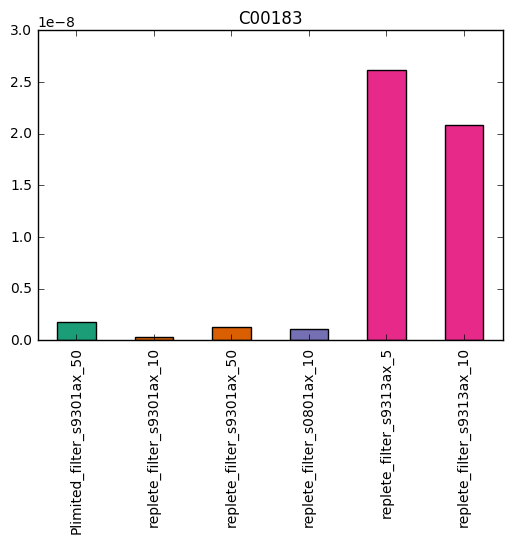

In [14]:
#test one...checking the loop
oneCpd = 'C00183'

df2 = mtabPruned.filter(regex = 'filter')
toPlot = df2.loc[oneCpd]
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
axs = toPlot.plot(kind = 'bar',color = useColors)
axs.set_title(oneCpd)

In [54]:
r = cpd_inNstrains[cpd_inNstrains.loc[:,'in3'].gt(0)] #in 3...perhaps 'core' mtabs in Pro

for item in r.index:
    #print(item)
    print(kegg_list(item).read())

cpd:C00671	(S)-3-Methyl-2-oxopentanoic acid; (S)-3-Methyl-2-oxopentanoate; (3S)-3-Methyl-2-oxopentanoic acid; (3S)-3-Methyl-2-oxopentanoate

cpd:C00233	4-Methyl-2-oxopentanoate; 2-Oxoisocaproate

cpd:C00020	AMP; Adenosine 5'-monophosphate; Adenylic acid; Adenylate; 5'-AMP; 5'-Adenylic acid; 5'-Adenosine monophosphate; Adenosine 5'-phosphate

cpd:C00062	L-Arginine; (S)-2-Amino-5-guanidinovaleric acid; L-Arg

cpd:C00111	Glycerone phosphate; Dihydroxyacetone phosphate; 3-Hydroxy-2-oxopropyl phosphate

cpd:C00025	L-Glutamate; L-Glutamic acid; L-Glutaminic acid; Glutamate

cpd:C00064	L-Glutamine; L-2-Aminoglutaramic acid

cpd:C00130	IMP; Inosinic acid; Inosine monophosphate; Inosine 5'-monophosphate; Inosine 5'-phosphate; 5'-Inosinate; 5'-Inosinic acid; 5'-Inosine monophosphate; 5'-IMP

cpd:C00051	Glutathione; 5-L-Glutamyl-L-cysteinylglycine; N-(N-gamma-L-Glutamyl-L-cysteinyl)glycine; gamma-L-Glutamyl-L-cysteinyl-glycine; GSH; Reduced glutathione

cpd:C00082	L-Tyrosine; (S)-3-(p-Hydroxyphen

In [78]:
sumCount = cpd_inNstrains.sum(axis=0)

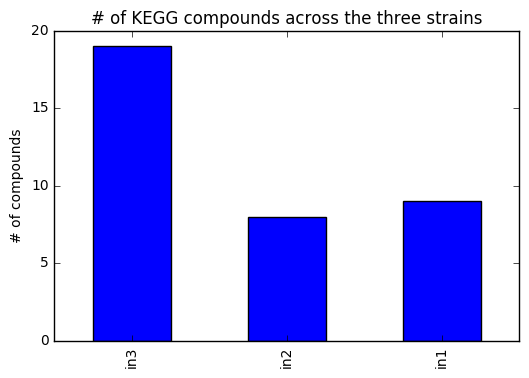

In [93]:
#remember - this is the subset of compounds I expect to find in all three strains...
#also...pre-screened to only be compounds we measured...this figure accounts for 
#anything with a value > 0
fig,axs = plt.subplots(1,1)
sumCount.loc[['in3','in2','in1']].plot(kind = 'bar')
axs.set_title('# of KEGG compounds across the three strains')
axs.set_ylabel('# of compounds')
fig.savefig('nCompounds.jpg')

In [111]:
fi = cpd_inNstrains[cpd_inNstrains.loc[:,'in2']==1]
countSub = fi.sum(axis=0)

In [124]:
fi1 = cpd_inNstrains[cpd_inNstrains.loc[:,'in1']==1]
countSub1 = fi1.sum(axis=0)

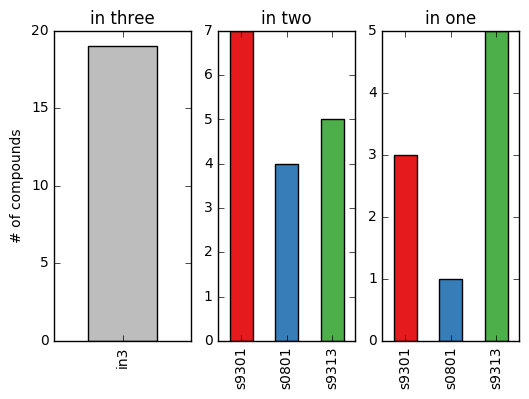

In [132]:
fig,axs = plt.subplots(1,3)
sumCount.loc[['in3']].plot(kind = 'bar',ax=axs[0],color = '#bdbdbd')
axs[0].set_title('in three')
axs[0].set_ylabel('# of compounds')
countSub.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title('in two')
countSub1.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[2])
axs[2].set_title('in one')
fig.savefig('compoundsSBin3.jpg')

In [146]:
fi1

,in3,in2,in1,in0,s9301,s0801,s9313
KEGG,,,,,,,
C00568,NaN,NaN,1,NaN,NaN,1,NaN
C00147,NaN,NaN,1,NaN,1,NaN,NaN
C00212,NaN,NaN,1,NaN,1,NaN,NaN
C01674,NaN,NaN,1,NaN,NaN,NaN,1
C00092,NaN,NaN,1,NaN,NaN,NaN,1
C00123,NaN,NaN,1,NaN,NaN,NaN,1
C00864,NaN,NaN,1,NaN,NaN,NaN,1
C00106,NaN,NaN,1,NaN,NaN,NaN,1
C00105,NaN,NaN,1,NaN,1,NaN,NaN


In [147]:
gI = fi1.index

In [148]:
for item in gI:
    if fi1.loc[item,'s9301']==1:
        print(kegg_list(item).read())

cpd:C00147	Adenine; 6-Aminopurine

cpd:C00212	Adenosine

cpd:C00105	UMP; Uridylic acid; Uridine monophosphate; Uridine 5'-monophosphate; 5'Uridylic acid



In [149]:
for item in gI:
    if fi1.loc[item,'s0801']==1:
        print(kegg_list(item).read())

cpd:C00568	4-Aminobenzoate; ABEE; 4-Aminobenzoic acid; p-Aminobenzoate



In [150]:
for item in gI:
    if fi1.loc[item,'s9313']==1:
        print(kegg_list(item).read())

cpd:C01674	Chitobiose; Diacetylchitobiose; N,N'-Diacetylchitobiose

cpd:C00092	D-Glucose 6-phosphate; Glucose 6-phosphate; Robison ester

cpd:C00123	L-Leucine; 2-Amino-4-methylvaleric acid; (2S)-alpha-2-Amino-4-methylvaleric acid; (2S)-alpha-Leucine

cpd:C00864	Pantothenate; Pantothenic acid; (R)-Pantothenate

cpd:C00106	Uracil



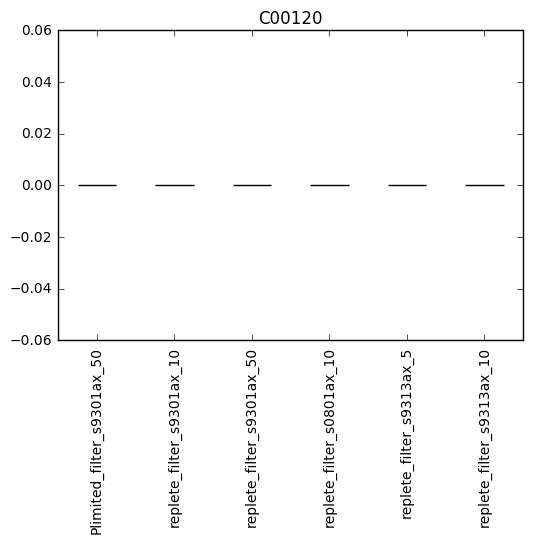

In [165]:
#test one...checking the loop
oneCpd = 'C00120'

df2 = mtabPruned.filter(regex = 'filter')
toPlot = df2.loc[oneCpd]
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
axs = toPlot.plot(kind = 'bar',color = useColors)
axs.set_title(oneCpd)

In [161]:
import dill                            #pip install dill --user
filename= 'globalsave.pkl'
dill.dump_session(filename)

In [160]:
import dill
# and to load the session again:
dill.load_session('globalsave.pkl')

In [ ]:
#leave debris below here for now, notebook will stop at the 'raise' 
#command in the next cell to keep me from running cells 
#of code that are not meant to be connected

In [ ]:
raise

In [ ]:
kegg_link('reaction','C00315').read()

kegg_link('pathway','C00315').read()

kegg_list('map00330').read()

kegg_link('compound','map00260').read()

In [ ]:
filter_cols = [col for col in mtabPruned if 'filter' in col]
#works, but I still need to wrap my head around the list comprehension

In [ ]:
#kegg_get(oneMap).read()
genes = getKfrom_ko(oneMap)
compounds = getCfrom_ko(oneMap)

setG = set(genes)
setC = set(compounds)
setT = set(useCO)
intCompounds = setC.intersection(setT)

useColors = pal.colorbrewer.diverging.PuOr_4.hex_colors
#useColors = pal.colorbrewer.diverging.RdYlBu_11.hex_colors

#set the color of the mtab based on its value, only scale the values from this particular pathway
useCOsubset = CO_values.loc[intCompounds]
cmin = useCOsubset.min() #find min and max...ignore NaN and inf for the moment
cmax = useCOsubset.replace([np.inf],np.nan).dropna(how = 'all').max()

size = 20 #increase the size of the compounds in the plots

pathway = KGML_parser.read(kegg_get(oneMap, "kgml")) #no choice in gene color: green

In [ ]:
        dummy = useCOsubset.copy(deep = True)
        dummy.replace([np.inf],np.nan,inplace = True)
        for idx,item in enumerate(useCOsubset):
            if np.isnan(item):
                useCOsubset.iloc[idx] = 0
            elif np.isinf(item):
                useCOsubset.iloc[idx] = 10*cmax #make inf 10x the biggest value

        #now, find cmax again...use that downstream
        cmax = useCOsubset.replace([np.inf],np.nan).dropna(how = 'all').max()

        #use histogram to make the bins (complete hack)
        a,bin_edges = np.histogram(useCOsubset,bins = len(useColors)-3,range = (cmin,cmax))
        #now...put zero at beginning and inf at end
        #BUT - can actually have cases with values for all metabolites (novel concept)
        try:
            nz = useCOsubset.value_counts()[0] #count the number of zeros
            a = np.insert(a,0,nz)
            bin_edges = np.insert(bin_edges,0,0)
        except:
            pass
            
        try:
            nm = useCOsubset.value_counts()[cmax]
            a = np.append(a,nm)
            bin_edges = np.append(bin_edges,cmax)
        except:
            pass

        #then find the index for each number...this will be the index into useColors
        useIdx = np.digitize(useCOsubset,bin_edges)
        color_df = pd.DataFrame({'mtab': useCOsubset,'idx':useIdx})

In [ ]:

# Change the colors of compounds
for element in pathway.compounds:
    for graphic in element.graphics:
        tc = element.name[4:10] #skip over the 'cpd:'
        if (tc in intCompounds):
            #in the pathway, set the color
            tempColor = useCOsubset.loc[tc]
            graphic.bgcolor = useColors[int(tempColor)] 
            graphic.width = size
            graphic.height = size

canvas = KGMLCanvas(oneMap, import_imagemap=True)
pdfName = 'mapWithColors_' + str(oneMap) + '.pdf'
canvas.draw('testingFolder' + '/' + pdfName)
pdfName = None #empty it in case that is where I am having issues       

In [72]:
#is this cpd in all three strains? or some lower number...
cpd_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0'])

for oneCpd in useCO:
    strains = {'s9301','s0801','s9313'}
    tMarker = pd.DataFrame(index = ['temp'],columns = ['s9301','s0801','s9313'])
    for st in strains:
        df2 = mtabPruned.loc[oneCpd].filter(regex = ('filter_' + st))
        r = df2[df2.gt(0)]
        if not r.empty:
            tMarker.loc['temp',st] = 1

    a = tMarker.sum(axis=1)

    #cpd_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0'])
    #a.loc['temp']
    if a.loc['temp'] == 3:
        cpd_inNstrains.loc[oneCpd,'in3'] = 1
    elif a.loc['temp'] == 2:
        cpd_inNstrains.loc[oneCpd,'in2'] = 1
    elif a.loc['temp'] == 1:
        cpd_inNstrains.loc[oneCpd,'in1'] = 1
    elif a.loc['temp'] == 0:
        cpd_inNstrains.loc[oneCpd,'in0'] = 1
        
    del a,tMarker

In [ ]:
#import plotByGroup
reload(plotByGroup)

In [ ]:
#for oneGroup in unMetabolismGroups:
oneGroup = 'Carbohydrate metabolism'

In [ ]:
plotByGroup.plotGroup(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain)

In [ ]:
    #oneStrain = 'pmg'
    shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
    onePath = shortList.loc[:,'map']
    onePath_ann = []
    for item in onePath:
        onePath_ann.append(oneStrain + item)

    gatherGroup = pd.DataFrame()
    for one in onePath_ann:
        #print(one)
        #not all pathways annotated in Prochlorococcus
        setKeep = 1
        try:
            kegg_get(one).read()
        except:
            #use the ko map if there is nothing species specific
            usePathway = 'ko' + one[3:8]
            setKeep = 0
            try:
                kegg_get(usePathway).read()
            except:
                pass
            
        if setKeep:
            usePathway = one
        
        try:
            mCpds = set(getCfrom_ko(usePathway))
        except:
            #no ko pathway either
            break
                          
        ProData= set(useCO)
        handh = mCpds.intersection(ProData)
        for cpd in handh:
            #print(cpd)
            #pdb.set_trace()
            tm = mtabPruned.loc[cpd,:]
            if (cpd in gatherGroup.index): 
                pass
            else: #only add the mtab if it is new...can have mtabs in multiple pathways
                gatherGroup = gatherGroup.append(tm)